In [1]:
#%env NDIVE_MODEL_PATH=/gpfs/slac/atlas/fs1/d/jshoe/saved_models/
%env NDIVE_MODEL_PATH=/gpfs/slac/atlas/fs1/d/recsmith/Vertexing/saved_models/

import matplotlib.pyplot as plt

import jax
import numpy as np
import torch # keep b/c dirty install

from functools import partial

import diffvert
import diffvert.models.NDIVE

MAX_NUM_TRACKS = 15
MODEL_INPUT_SHAPE = [10,MAX_NUM_TRACKS,51]


env: NDIVE_MODEL_PATH=/gpfs/slac/atlas/fs1/d/recsmith/Vertexing/saved_models/


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# reload local module so can use in development. must re-run on module change
import importlib
importlib.reload(diffvert)
importlib.reload(diffvert.models.NDIVE)
importlib.reload(diffvert.utils.data_format)
importlib.reload(diffvert.models.train_config)
import diffvert.evaluation.plot_helpers as ph

import diffvert.utils.data_format as daf
# from diffvert.utils.data_format import JetPrediction, JetData, NUM_JET_INPUT_PARAMETERS

importlib.reload(diffvert.evaluation.plot_helpers)
import diffvert.evaluation.plot_helpers as ph


In [3]:
DEVICE_COUNT = jax.device_count()
print(DEVICE_COUNT)
TEST_VMAP_COUNT = 50
print(TEST_VMAP_COUNT)
jax.devices()

2
50


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0)]

In [4]:
""" Load in test outputs for some config, epoch. Also load in outputs for ndive only model """
config_name = "ftag_all_loss"
INCLUDE_GHOST = False

ftag_outs = ph.get_test_output("final_ftag_ndive", None, 0)
ndive_outs = ph.get_test_output("final_ndive_only")

print(f"input shapes  -> b: {ftag_outs['b_input_arr'].shape}, c: {ftag_outs['c_input_arr'].shape}, u: {ftag_outs['u_input_arr'].shape}")
print(f"output shapes -> b: {ftag_outs['b_output_arr'].shape}, c: {ftag_outs['c_output_arr'].shape}, u: {ftag_outs['u_output_arr'].shape}")


found previous cached outputs
found previous cached outputs
input shapes  -> b: (60000, 15, 51), c: (60000, 15, 51), u: (60000, 15, 51)
output shapes -> b: (60000, 30), c: (60000, 30), u: (60000, 30)


In [7]:
! ls /gpfs/slac/atlas/fs1/d/jshoe/saved_models/ndive_only

100  125  150  175  200  25  50  75  checkpoint_0  losses.json


In [5]:
""" Analyze parameter count of some model. """
pcount, params = ph.get_param_count("ftag_all_loss", None, 0)

print("total params:", pcount)
print(params.keys())

def get_tot_params(plist):
    return sum(x.size for x in jax.tree_util.tree_leaves(plist))

# print("dense 0 keys:", params["Dense_0"].keys())

tenc = params["TransformerEncoder_0"]
print(tenc["SelfAttention_0"].keys())
kernel = tenc["SelfAttention_0"]["key"]["kernel"]
print(kernel.shape)

for subkey in tenc.keys():
    print(subkey, get_tot_params(tenc[subkey]))

kernel = tenc["SelfAttention_0"]["key"]["kernel"]
# plt.hist(kernel.ravel())
# print(pcount)
# print(params["TransformerEncoder_0"].keys())
# print(params["Network_0"].keys())
# print(sum(x.size for x in jax.tree_util.tree_leaves(params["TransformerEncoder_0"])))
# print(params["TransformerEncoder_0"].keys())
# print(sum(x.size for x in jax.tree_util.tree_leaves(params["TransformerEncoder_0"]["SelfAttention_0"])))
# for subkey in params["TransformerEncoder_0"].keys():
#     print("  ", subkey, sum(x.size for x in jax.tree_util.tree_leaves(params["TransformerEncoder_0"][subkey])))


/gpfs/slac/atlas/fs1/d/recsmith/Vertexing/saved_models/ftag_all_loss/model_0


TypeError: 'NoneType' object is not subscriptable

## Done with Data Loading, Start Graphing

In [6]:
importlib.reload(diffvert.evaluation.plot_helpers)
import diffvert.evaluation.plot_helpers as ph

### Look at how often correct flavor is plurality prediction

Text(0.5, 0, 'light-jet $p_T$ [GeV]')

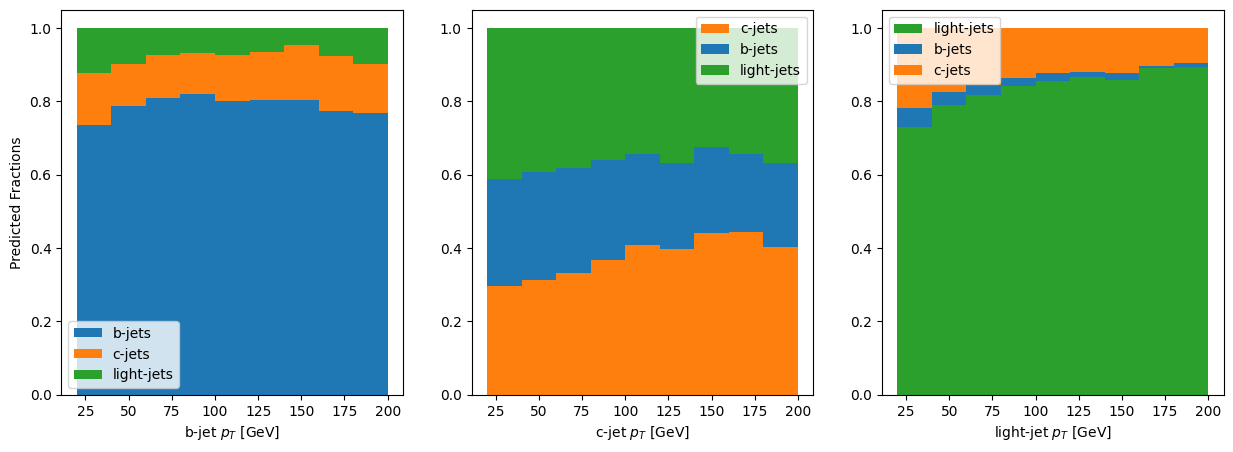

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
# fig, ax = plt.subplots(1)
bins = np.linspace(20, 200, 10)

def get_jet_pt(inputs):
    """ get pt by jet """ 
    return inputs[:,0,daf.JetData.TRACK_JET_PT]

ph.graph_stacked_bar(
    [ph.get_b_pred, ph.get_c_pred, ph.get_u_pred],
    get_jet_pt,
    ax1,
    bins,
    jet_outs=ftag_outs["b_output_arr"],
    jet_ins=ftag_outs["b_input_arr"],
    output_names=["b-jets","c-jets","light-jets"],
    colors=["#1f77b4", "#ff7f0e", "#2ca02c"],
)

ph.graph_stacked_bar(
    [ph.get_c_pred, ph.get_b_pred, ph.get_u_pred],
    get_jet_pt,
    ax2,
    bins,
    jet_outs=ftag_outs["c_output_arr"],
    jet_ins=ftag_outs["c_input_arr"],
    output_names=["c-jets","b-jets","light-jets"],
    colors=["#ff7f0e", "#1f77b4", "#2ca02c"],
)

ph.graph_stacked_bar(
    [ph.get_u_pred, ph.get_b_pred, ph.get_c_pred],
    get_jet_pt,
    ax3,
    bins,
    jet_outs=ftag_outs["u_output_arr"],
    jet_ins=ftag_outs["u_input_arr"],
    output_names=["light-jets", "b-jets","c-jets"],
    colors=["#2ca02c", "#1f77b4", "#ff7f0e"],
)

ax1.set_ylabel("Predicted Fractions")
ax1.set_xlabel("b-jet $p_T$ [GeV]")
ax2.set_xlabel("c-jet $p_T$ [GeV]")
ax3.set_xlabel("light-jet $p_T$ [GeV]")

/sdf/home/m/miochoa/Differentiable-Vertexing-Project/diffvert/evaluation/plot_helpers.py:524: RuntimeWarning: invalid value encountered in divide
  bin_mids, bar_set/in_counts, width=bin_width,
/sdf/home/m/miochoa/Differentiable-Vertexing-Project/diffvert/evaluation/plot_helpers.py:527: RuntimeWarning: invalid value encountered in divide
  bottom += bar_set/in_counts


Text(0.5, 0, 'light-jet Number of tracks')

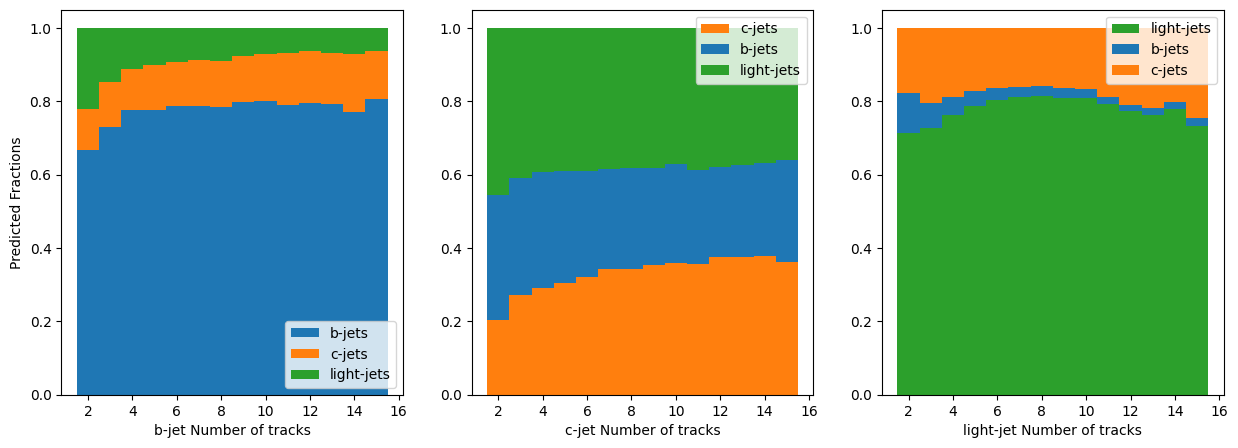

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
# fig, ax = plt.subplots(1)
bins = np.arange(0.5,16,1)

def get_jet_tot_tracks(inputs):
    """ get pt by jet """ 
    return inputs[:,0,daf.JetData.N_TRACKS]

ph.graph_stacked_bar(
    [ph.get_b_pred, ph.get_c_pred, ph.get_u_pred],
    get_jet_tot_tracks,
    ax1,
    bins,
    jet_outs=ftag_outs["b_output_arr"],
    jet_ins=ftag_outs["b_input_arr"],
    output_names=["b-jets","c-jets","light-jets"],
    colors=["#1f77b4", "#ff7f0e", "#2ca02c"],
)

ph.graph_stacked_bar(
    [ph.get_c_pred, ph.get_b_pred, ph.get_u_pred],
    get_jet_tot_tracks,
    ax2,
    bins,
    jet_outs=ftag_outs["c_output_arr"],
    jet_ins=ftag_outs["c_input_arr"],
    output_names=["c-jets","b-jets","light-jets"],
    colors=["#ff7f0e", "#1f77b4", "#2ca02c"],
)

ph.graph_stacked_bar(
    [ph.get_u_pred, ph.get_b_pred, ph.get_c_pred],
    get_jet_tot_tracks,
    ax3,
    bins,
    jet_outs=ftag_outs["u_output_arr"],
    jet_ins=ftag_outs["u_input_arr"],
    output_names=["light-jets", "b-jets","c-jets"],
    colors=["#2ca02c", "#1f77b4", "#ff7f0e"],
)

ax1.set_ylabel("Predicted Fractions")
ax1.set_xlabel("b-jet Number of tracks")
ax2.set_xlabel("c-jet Number of tracks")
ax3.set_xlabel("light-jet Number of tracks")

Text(0.5, 0, 'light-jet Number of tracks from decay')

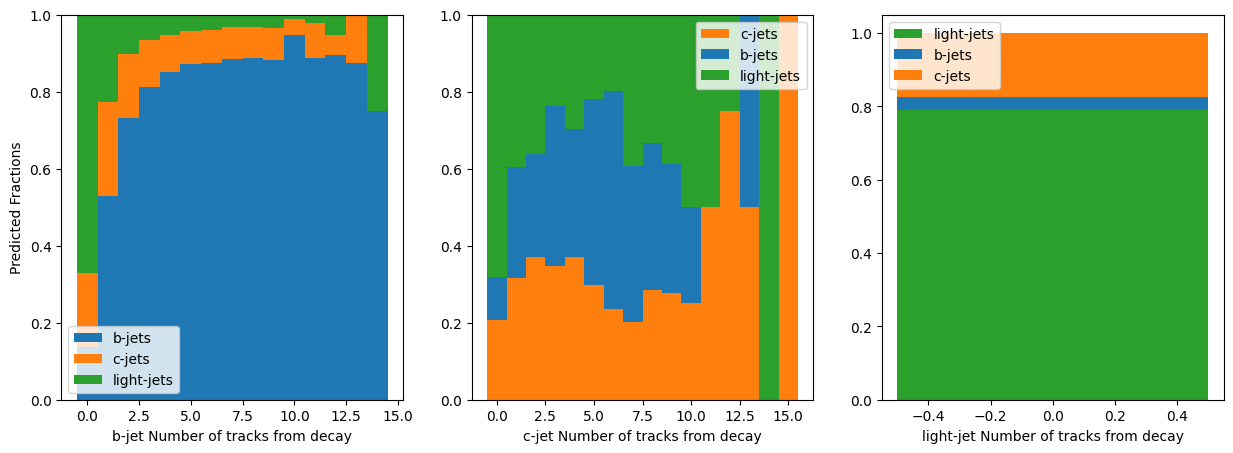

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
# fig, ax = plt.subplots(1)
bins = np.arange(-.5,16,1)

def get_jet_tracks_from_decay(inputs):
    """ get pt by jet """ 
    from_decay = np.logical_or(
        inputs[:,:,daf.JetData.TRACK_FROM_B].astype(int)==1,
        inputs[:,:,daf.JetData.TRACK_FROM_C].astype(int)==1
    )
    return np.sum(from_decay, axis=1)

ph.graph_stacked_bar(
    [ph.get_b_pred, ph.get_c_pred, ph.get_u_pred],
    get_jet_tracks_from_decay,
    ax1,
    bins,
    jet_outs=ftag_outs["b_output_arr"],
    jet_ins=ftag_outs["b_input_arr"],
    output_names=["b-jets","c-jets","light-jets"],
    colors=["#1f77b4", "#ff7f0e", "#2ca02c"],
)

ph.graph_stacked_bar(
    [ph.get_c_pred, ph.get_b_pred, ph.get_u_pred],
    get_jet_tracks_from_decay,
    ax2,
    bins,
    jet_outs=ftag_outs["c_output_arr"],
    jet_ins=ftag_outs["c_input_arr"],
    output_names=["c-jets","b-jets","light-jets"],
    colors=["#ff7f0e", "#1f77b4", "#2ca02c"],
)

ph.graph_stacked_bar(
    [ph.get_u_pred, ph.get_b_pred, ph.get_c_pred],
    get_jet_tracks_from_decay,
    ax3,
    bins,
    jet_outs=ftag_outs["u_output_arr"],
    jet_ins=ftag_outs["u_input_arr"],
    output_names=["light-jets", "b-jets","c-jets"],
    colors=["#2ca02c", "#1f77b4", "#ff7f0e"],
)

ax1.set_ylabel("Predicted Fractions")
ax1.set_xlabel("b-jet Number of tracks from decay")
ax2.set_xlabel("c-jet Number of tracks from decay")
ax3.set_xlabel("light-jet Number of tracks from decay")

/tmp/ipykernel_11535/2356947120.py:7: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(outputs[:,daf.JetPrediction.VERTEX_COV_XX])
/tmp/ipykernel_11535/2356947120.py:11: RuntimeWarning: divide by zero encountered in divide
  return (outputs[:,daf.JetPrediction.VERTEX_Y] - inputs[:,0,daf.JetData.HADRON_Y]) \
/tmp/ipykernel_11535/2356947120.py:12: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(outputs[:,daf.JetPrediction.VERTEX_COV_YY])
/tmp/ipykernel_11535/2356947120.py:16: RuntimeWarning: divide by zero encountered in divide
  return (outputs[:,daf.JetPrediction.VERTEX_Z] - inputs[:,0,daf.JetData.HADRON_Z]) \
/tmp/ipykernel_11535/2356947120.py:17: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(outputs[:,daf.JetPrediction.VERTEX_COV_ZZ])


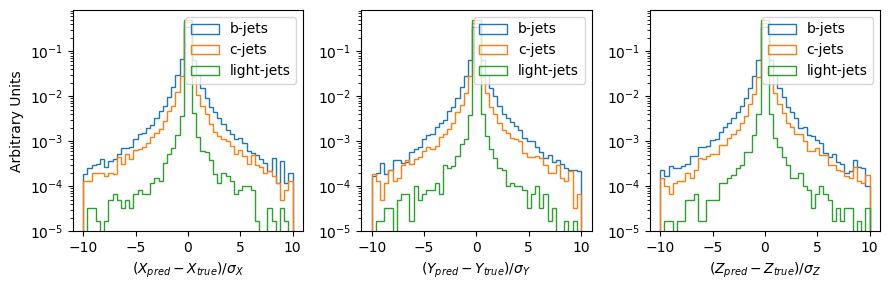

In [10]:
""" Graph z-score for vertex prediction, as given by fit output and covariance. """
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
hist_options = dict(range=(-10, 10), bins=50, log=True)
def get_x_zscore(outputs, inputs, has_ghost=True):
    """ return z score for vertex x output """
    return (outputs[:,daf.JetPrediction.VERTEX_X] - inputs[:,0,daf.JetData.HADRON_X]) \
            / np.sqrt(outputs[:,daf.JetPrediction.VERTEX_COV_XX])

def get_y_zscore(outputs, inputs, has_ghost=True):
    """ return y score for vertex y output """
    return (outputs[:,daf.JetPrediction.VERTEX_Y] - inputs[:,0,daf.JetData.HADRON_Y]) \
            / np.sqrt(outputs[:,daf.JetPrediction.VERTEX_COV_YY])

def get_z_zscore(outputs, inputs, has_ghost=True):
    """ return z score for vertex z output """
    return (outputs[:,daf.JetPrediction.VERTEX_Z] - inputs[:,0,daf.JetData.HADRON_Z]) \
            / np.sqrt(outputs[:,daf.JetPrediction.VERTEX_COV_ZZ])

ph.graph_output_info(
    get_x_zscore,
    ax1,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    hist_options=hist_options,
    labels=["b-jets", "c-jets", "light-jets"],
    plot_avgs=False
)
ph.graph_output_info(
    get_y_zscore,
    ax2,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    hist_options=hist_options,
    labels=["b-jets", "c-jets", "light-jets"],
    plot_avgs=False
)
ph.graph_output_info(
    get_z_zscore,
    ax3,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    hist_options=hist_options,
    labels=["b-jets", "c-jets", "light-jets"],
    plot_avgs=False
)

ax1.set_ylabel("Arbitrary Units")
ax1.set_xlabel('$(X_{pred} - X_{true})/\sigma_X$')
ax2.set_xlabel('$(Y_{pred} - Y_{true})/\sigma_Y$')
ax3.set_xlabel('$(Z_{pred} - Z_{true})/\sigma_Z$')
fig.tight_layout()
plt.show()

/tmp/ipykernel_11535/1143076243.py:8: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(outputs[:,daf.JetPrediction.VERTEX_COV_XX])
/tmp/ipykernel_11535/1143076243.py:13: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(outputs[:,daf.JetPrediction.VERTEX_COV_YY])
/tmp/ipykernel_11535/1143076243.py:18: RuntimeWarning: invalid value encountered in sqrt
  / np.sqrt(outputs[:,daf.JetPrediction.VERTEX_COV_ZZ])


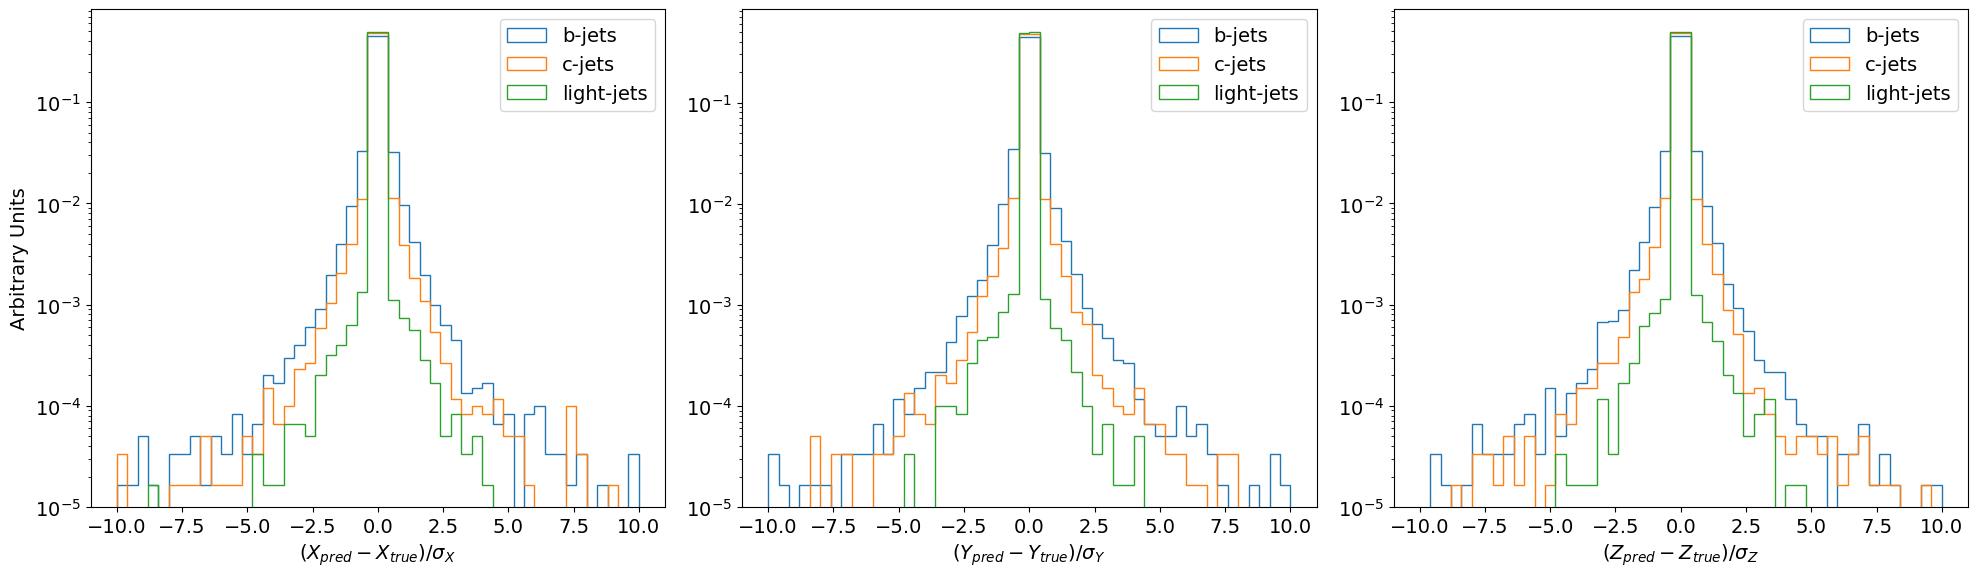

In [11]:
""" Graph z-score for vertex prediction, as given by fit output and covariance. """
plt.rcParams["font.size"]=14
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))
hist_options = dict(range=(-10, 10), bins=50, log=True)
def get_x_zscore(outputs, inputs, has_ghost=True):
    """ return z score for vertex x output """
    return (outputs[:,daf.JetPrediction.VERTEX_X] - inputs[:,0,daf.JetData.HADRON_X]) \
            / np.sqrt(outputs[:,daf.JetPrediction.VERTEX_COV_XX])

def get_y_zscore(outputs, inputs, has_ghost=True):
    """ return y score for vertex y output """
    return (outputs[:,daf.JetPrediction.VERTEX_Y] - inputs[:,0,daf.JetData.HADRON_Y]) \
            / np.sqrt(outputs[:,daf.JetPrediction.VERTEX_COV_YY])

def get_z_zscore(outputs, inputs, has_ghost=True):
    """ return z score for vertex z output """
    return (outputs[:,daf.JetPrediction.VERTEX_Z] - inputs[:,0,daf.JetData.HADRON_Z]) \
            / np.sqrt(outputs[:,daf.JetPrediction.VERTEX_COV_ZZ])

ph.graph_output_info(
    get_x_zscore,
    ax1,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    hist_options=hist_options,
    labels=["b-jets", "c-jets", "light-jets"],
    plot_avgs=False
)
ph.graph_output_info(
    get_y_zscore,
    ax2,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    hist_options=hist_options,
    labels=["b-jets", "c-jets", "light-jets"],
    plot_avgs=False
)
ph.graph_output_info(
    get_z_zscore,
    ax3,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    hist_options=hist_options,
    labels=["b-jets", "c-jets", "light-jets"],
    plot_avgs=False
)

ax1.set_ylabel("Arbitrary Units")
ax1.set_xlabel('$(X_{pred} - X_{true})/\sigma_X$')
ax2.set_xlabel('$(Y_{pred} - Y_{true})/\sigma_Y$')
ax3.set_xlabel('$(Z_{pred} - Z_{true})/\sigma_Z$')
fig.tight_layout()
plt.savefig("plots/ndive_score.png")

### Look at performance of track weighting / selection

shapes: good:(218039,), bad:(208713,)
shapes: good:(109591,), bad:(315729,)
shapes: good:(0,), bad:(425764,)


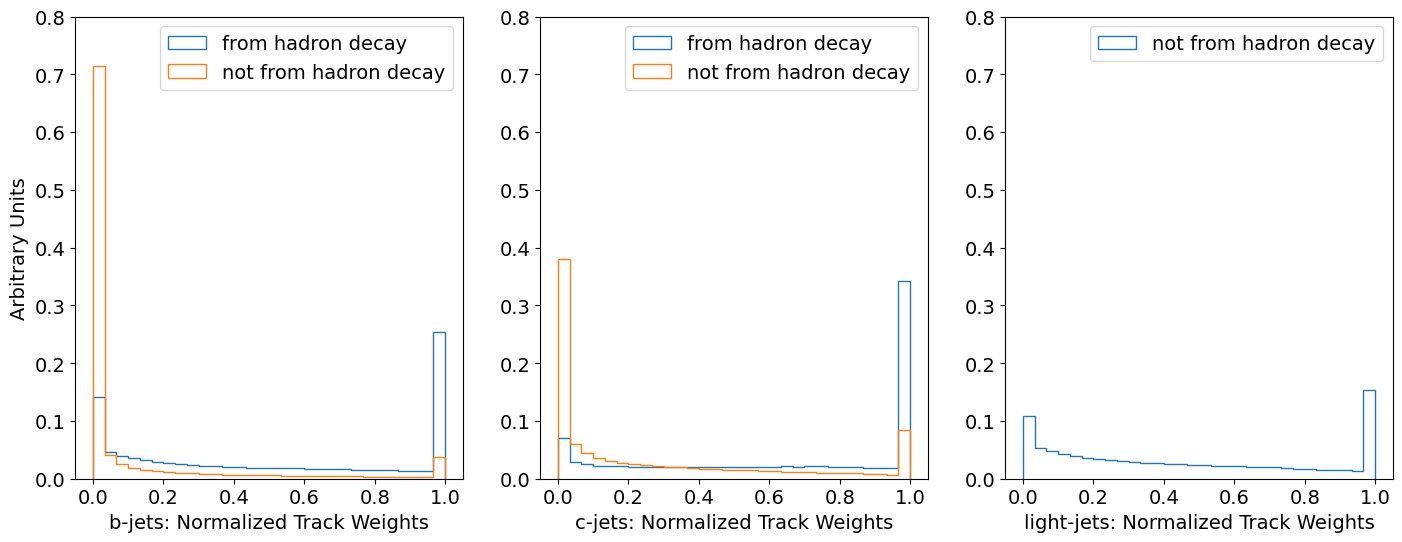

In [12]:
def plot_weights(ax, outputs, inputs, normalize_by_max=True, 
                include_ghost_norm=True, has_ghost=True, cumulative=False,
                ):
    """ plot distribution of track-weights for good and bad tracks separately

    idea is to try to get a good way of making a cut on weights
    Args:
        ax: plotting axis
        outputs: model outputs
        inputs: model inputs
        normalize_by_max: whether or not to normalize track weights by max track weight in jet
        include_ghost_norm: whether or not to include ghost track weight when normalizing
        has_ghost: whether or not model includes ghost track
        cumulative: make histogram more like cdf
    """
    track_weights = outputs[:,daf.JetPrediction.VERTEX_TRACK_STARTS:daf.JetPrediction.VERTEX_TRACK_STARTS+MAX_NUM_TRACKS+has_ghost]

    if not include_ghost_norm and has_ghost:
        track_weights = track_weights[:,1:] # remove ghost track
    
    normalized_track_weights = track_weights
    if normalize_by_max:
        normalized_track_weights = normalized_track_weights / np.max(track_weights, axis=1).reshape(-1,1)

    if include_ghost_norm and has_ghost:
        normalized_track_weights = normalized_track_weights[:,1:] # remove ghost track

    num_jets, max_num_tracks = inputs.shape[0:2]
    n_trks = inputs[:,0,daf.JetData.N_TRACKS]
    n_trks_rep = np.repeat(n_trks, max_num_tracks).reshape((num_jets, max_num_tracks))
    indices = np.tile(np.arange(0, max_num_tracks), num_jets).reshape((num_jets, max_num_tracks))
    take = (indices < n_trks_rep)

    from_decay = ph.get_tracks_from_decay(inputs)

    good_weights = normalized_track_weights[np.logical_and(take, from_decay)]
    bad_weights = normalized_track_weights[np.logical_and(take, np.logical_not(from_decay))]

    print(f"shapes: good:{good_weights.shape}, bad:{bad_weights.shape}")

    bins_good, ns_good = None, 0
    if len(good_weights) > 0: # just for u-jets
      ns_good, bins_good, _ = ax.hist(
        good_weights, bins=30, histtype='step', label='from hadron decay',
        weights=np.repeat(1/len(good_weights), len(good_weights)), cumulative=cumulative,
      )
    ns_bad, bins_bad, _ = ax.hist(
       bad_weights, bins=30, histtype='step', label='not from hadron decay',
       weights=np.repeat(1/len(bad_weights), len(bad_weights)), cumulative=cumulative
    )
    ax.legend()
    return bins_good, ns_good/ns_bad


# FTAG + NDIVE MODEL
plt.rcParams["font.size"] = 14
#fig, ((ax1, ax2, ax5), (ax3, ax4, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
fig, ((ax1, ax2, ax5)) = plt.subplots(1, 3, figsize=(17, 6))
ratio_bins, b_ratio_values = plot_weights(
    ax1, ftag_outs["b_output_arr"], ftag_outs["b_input_arr"], 
    normalize_by_max=True, has_ghost=INCLUDE_GHOST,
)
_, c_ratio_values = plot_weights(
   ax2, ftag_outs["c_output_arr"], ftag_outs["c_input_arr"], 
   normalize_by_max=True, has_ghost=INCLUDE_GHOST,
)

ax1.set_xlabel("b-jets: Normalized Track Weights")
ax2.set_xlabel("c-jets: Normalized Track Weights")
ax1.set_ylim([0.0, 0.8])
ax2.set_ylim([0.0, 0.8])
ax1.set_ylabel("Arbitrary Units")

plot_weights(
    ax5, ftag_outs["u_output_arr"], ftag_outs["u_input_arr"],
    normalize_by_max=True, has_ghost=INCLUDE_GHOST,
)
ax5.set_xlabel("light-jets: Normalized Track Weights")
ax5.set_ylim([0.0, 0.8])
'''
ratio_mids = [(a+b)/2 for a, b in zip(ratio_bins, ratio_bins[1:])]
ax3.bar(ratio_mids, b_ratio_values, width=1/len(ratio_mids), fill=False)
ax3.set_xlabel("b-jet: good / bad")
ax3.axhline(1.0)
ax4.bar(ratio_mids, c_ratio_values, width=1/len(ratio_mids), fill=False)
#ax4.set_xlabel("c-jet ratio of histogram values good / bad")
ax4.set_xlabel("c-jet: good / bad")
ax4.axhline(1.0)

plot_weights(
    ax6, ftag_outs["b_output_arr"], ftag_outs["b_input_arr"],
    normalize_by_max=True, cumulative=True, has_ghost=INCLUDE_GHOST,
)
ax6.set_xlabel("b jets cdf")
'''

plt.savefig("plots/ftagndive_trackweights.png")

shapes: good:(218039,), bad:(208713,)
shapes: good:(109591,), bad:(315729,)
shapes: good:(0,), bad:(425764,)


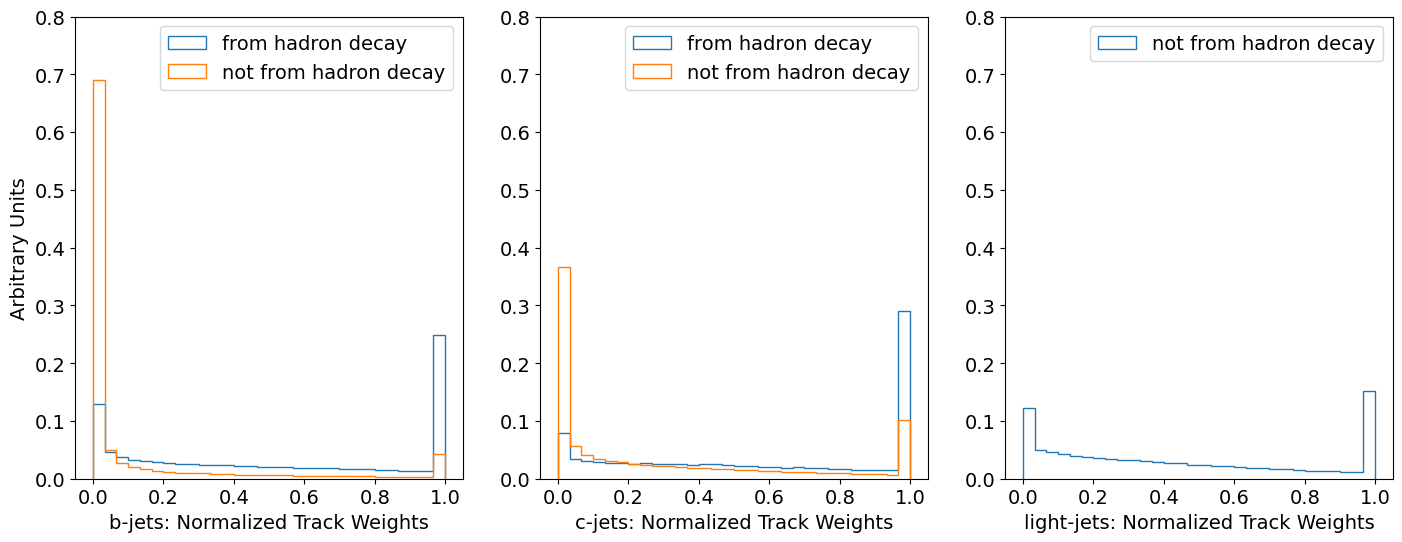

In [14]:
# NDIVE ONLY MODEL
plt.rcParams["font.size"] = 14
#fig, ((ax1, ax2, ax5), (ax3, ax4, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
fig, ((ax1, ax2, ax5)) = plt.subplots(1, 3, figsize=(17, 6))
ratio_bins, b_ratio_values = plot_weights(
    ax1, ndive_outs["b_output_arr"], ndive_outs["b_input_arr"], 
    normalize_by_max=True, has_ghost=INCLUDE_GHOST,
)
_, c_ratio_values = plot_weights(
   ax2, ndive_outs["c_output_arr"], ndive_outs["c_input_arr"], 
   normalize_by_max=True, has_ghost=INCLUDE_GHOST,
)

ax1.set_xlabel("b-jets: Normalized Track Weights")
ax2.set_xlabel("c-jets: Normalized Track Weights")
ax1.set_ylim([0.0, 0.8])
ax2.set_ylim([0.0, 0.8])
ax1.set_ylabel("Arbitrary Units")

plot_weights(
    ax5, ndive_outs["u_output_arr"], ndive_outs["u_input_arr"],
    normalize_by_max=True, has_ghost=INCLUDE_GHOST,
)
ax5.set_xlabel("light-jets: Normalized Track Weights")
ax5.set_ylim([0.0, 0.8])

'''
ratio_mids = [(a+b)/2 for a, b in zip(ratio_bins, ratio_bins[1:])]
ax3.bar(ratio_mids, b_ratio_values, width=1/len(ratio_mids), fill=False)
ax3.set_xlabel("b-jet: good / bad")
ax3.axhline(1.0)
ax4.bar(ratio_mids, c_ratio_values, width=1/len(ratio_mids), fill=False)
#ax4.set_xlabel("c-jet ratio of histogram values good / bad")
ax4.set_xlabel("c-jet: good / bad")
ax4.axhline(1.0)

plot_weights(
    ax6, ndive_outs["b_output_arr"], ndive_outs["b_input_arr"],
    normalize_by_max=True, cumulative=True, has_ghost=INCLUDE_GHOST,
)
ax6.set_xlabel("b jets cdf")
'''
plt.savefig("plots/ndive_trackweights.png")

In [15]:
""" Graph distribution of weights given to the ghost track. """
def get_ghost_track_weights(outputs, inputs=None, has_ghost=True):
    track_weights = outputs[:,daf.JetPrediction.VERTEX_TRACK_STARTS:daf.JetPrediction.VERTEX_TRACK_STARTS+MAX_NUM_TRACKS+1]
    track_weights = track_weights / np.max(track_weights, axis=1).reshape(-1,1)

    ghost_track_weights = track_weights[:,0]
    return ghost_track_weights

if INCLUDE_GHOST: # only makes sense if model used ghost track
    fig, ax1 = plt.subplots()
    ph.graph_output_info(
        get_ghost_track_weights,
        ax1,
        outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
        ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    )
    ax1.set_ylim([0.0,1.0])
    ax1.set_xlabel("Normalized weight of ghost track")



 Calculating Efficiency...
num should be shape: min: 0, max: 14
  nan count in efficiency calculation: 1890 -> 3.15%
 --- Num jets without tracks from decay: 1890

 Calculating Efficiency...
num should be shape: min: 0, max: 15
  nan count in efficiency calculation: 8285 -> 13.81%
 --- Num jets without tracks from decay: 8285


/sdf/home/m/miochoa/Differentiable-Vertexing-Project/diffvert/evaluation/plot_helpers.py:585: RuntimeWarning: invalid value encountered in divide
  percent_correct = k / N



 Calculating purity...
  nan count in purity calculation: 0 -> 0.00%
 --- Num no tracks with w > 0.5 (zero count in denominator): 0

 Calculating purity...
  nan count in purity calculation: 0 -> 0.00%
 --- Num no tracks with w > 0.5 (zero count in denominator): 0


'done'

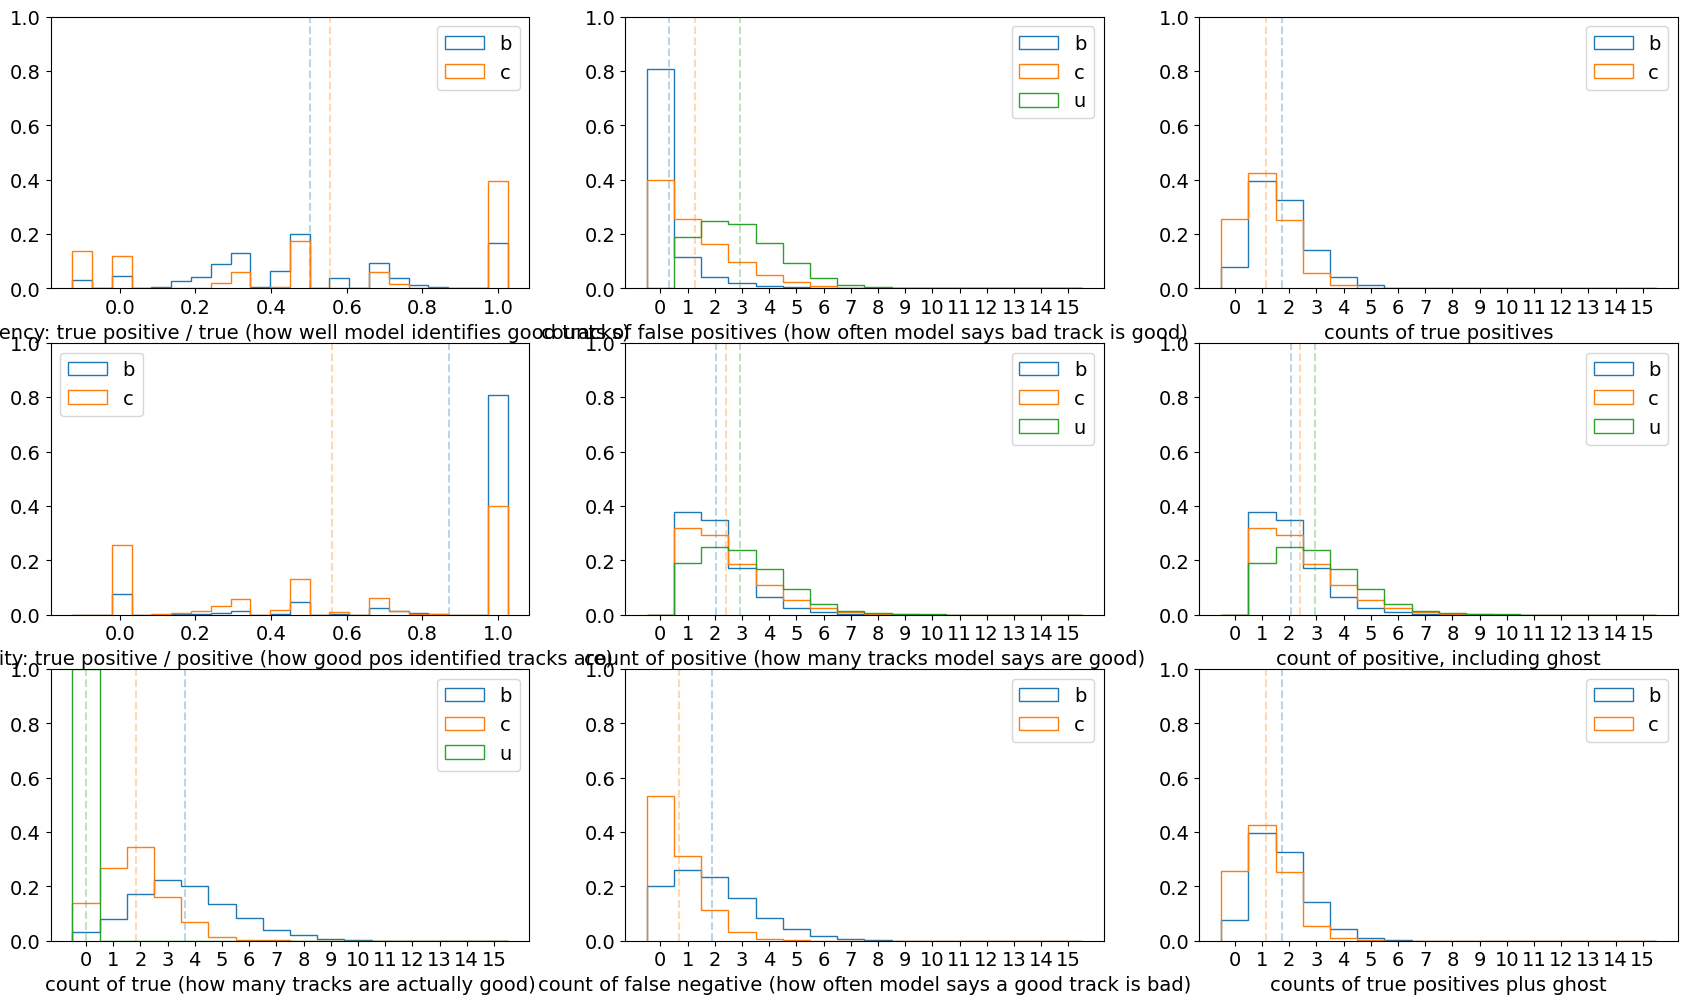

In [16]:
""" Graph a bunch of properties of track selection.

Tracks are selected if the weight they are assigned is above a threshold times the maximum
weight assigned to some track in that jet.
"""

# FTAG+ndive model

threshold=0.5
    
fig, ((ax1, ax2, ax7), (ax3, ax4, ax8), (ax5, ax6, ax9)) = plt.subplots(3,3, figsize=(21,12))
hist_options = dict(bins=22, range=(-0.125, 1.025)) # allow nans at -.1, center around 0
ph.graph_output_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    ax1,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"]],
    nan_val=-.1,
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax1.set_xlabel("efficiency: true positive / true (how well model identifies good tracks)")
ax1.set_ylim([0.0, 1.0])

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_false_positive, threshold=threshold),
    ax2,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax2.set_xlabel("counts of false positives (how often model says bad track is good)")
ax2.set_ylim([0.0, 1.0])
ax2.set_xticks(range(16))

hist_options = dict(bins=22, range=(-0.125, 1.025)) # allow nans at -.1, center around 0
ph.graph_output_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    ax3,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"]],
    nan_val=-.1,
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax3.set_xlabel("purity: true positive / positive (how good pos identified tracks are)")
ax3.set_ylim([0.0, 1.0])

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_positive, threshold=threshold),
    ax4,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax4.set_xlabel("count of positive (how many tracks model says are good)")
ax4.set_ylim([0.0, 1.0])
ax4.set_xticks(range(16))

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    ph.get_num_true,
    ax5,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax5.set_xlabel("count of true (how many tracks are actually good)")
ax5.set_ylim([0.0, 1.0])
ax5.set_xticks(range(16))

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_false_negative, threshold=threshold),
    ax6,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax6.set_xlabel("count of false negative (how often model says a good track is bad)")
ax6.set_ylim([0.0, 1.0])
ax6.set_xticks(range(16))

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_true_positive, threshold=threshold),
    ax7,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax7.set_xlabel("counts of true positives")
ax7.set_ylim([0.0, 1.0])
ax7.set_xticks(range(16))

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_positive, threshold=threshold, remove_ghost_track=False),
    ax8,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax8.set_xlabel("count of positive, including ghost")
ax8.set_ylim([0.0, 1.0])
ax8.set_xticks(range(16))


hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_true_positive_plus_ghost, threshold=threshold),
    ax9,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax9.set_xlabel("counts of true positives plus ghost")
ax9.set_ylim([0.0, 1.0])
ax9.set_xticks(range(16))

'done'


 Calculating Efficiency...
num should be shape: min: 0, max: 14
  nan count in efficiency calculation: 1890 -> 3.15%
 --- Num jets without tracks from decay: 1890

 Calculating Efficiency...
num should be shape: min: 0, max: 15
  nan count in efficiency calculation: 8285 -> 13.81%
 --- Num jets without tracks from decay: 8285

 Calculating purity...
  nan count in purity calculation: 0 -> 0.00%
 --- Num no tracks with w > 0.5 (zero count in denominator): 0

 Calculating purity...
  nan count in purity calculation: 0 -> 0.00%
 --- Num no tracks with w > 0.5 (zero count in denominator): 0


'done'

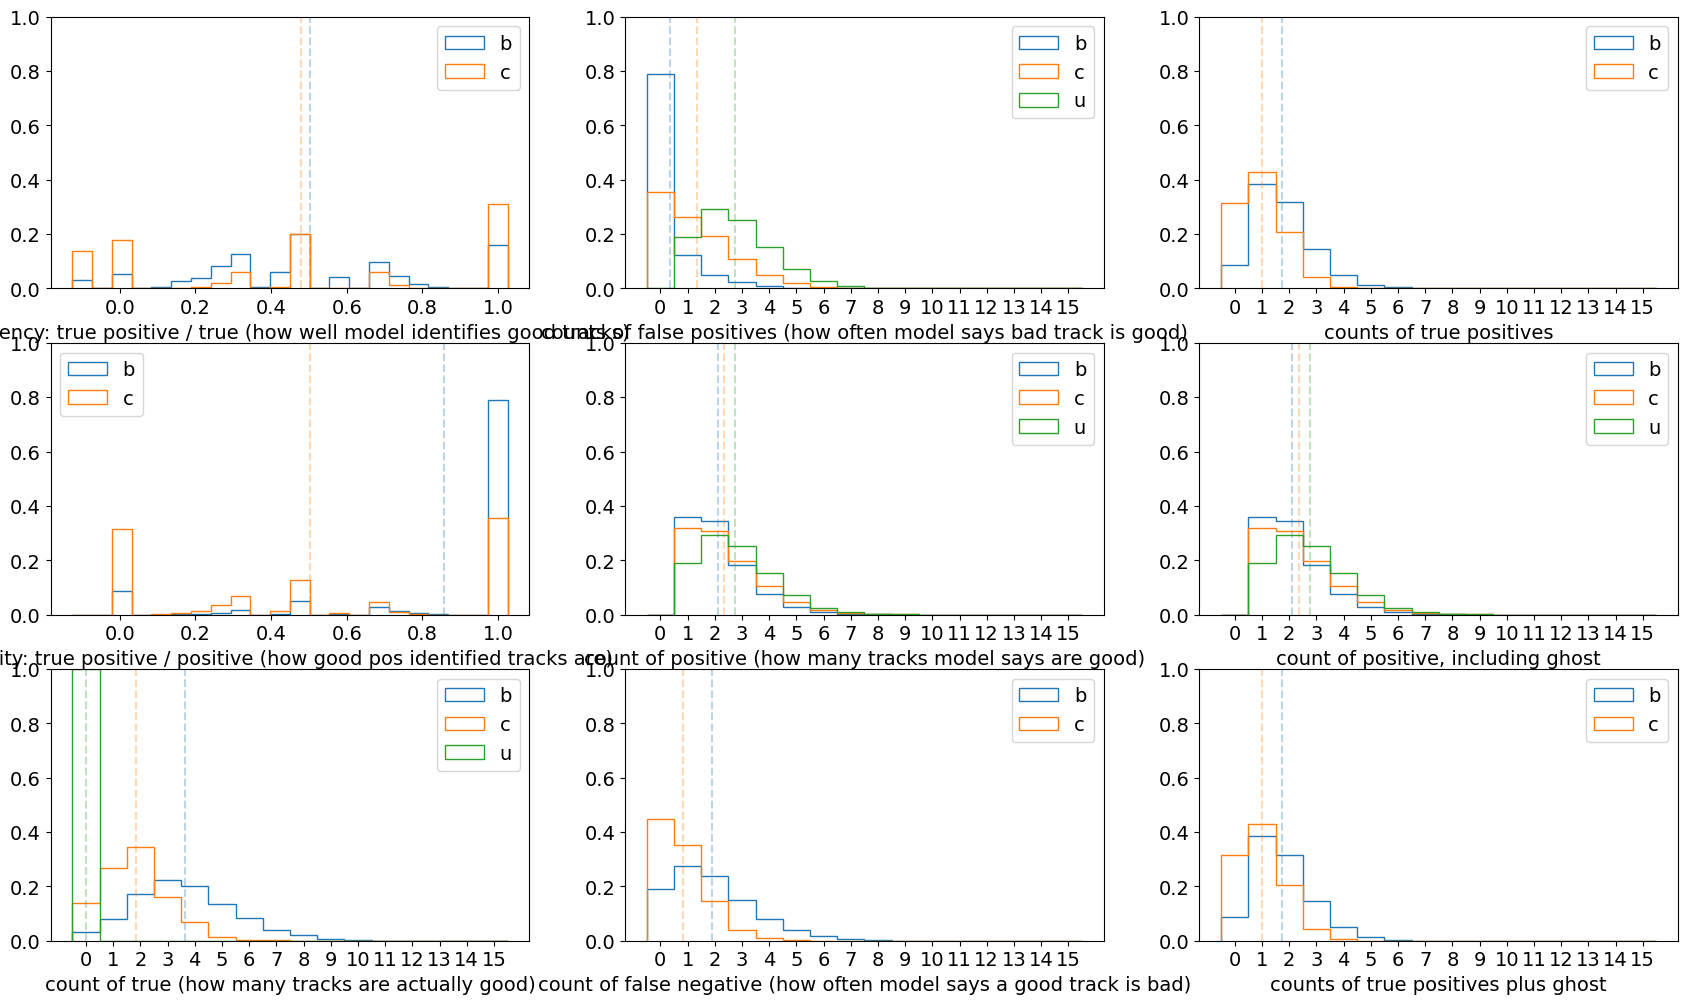

In [17]:
""" Graph a bunch of properties of track selection.

Tracks are selected if the weight they are assigned is above a threshold times the maximum
weight assigned to some track in that jet.
"""

# ndive-only model

threshold=0.5
    
fig, ((ax1, ax2, ax7), (ax3, ax4, ax8), (ax5, ax6, ax9)) = plt.subplots(3,3, figsize=(21,12))
hist_options = dict(bins=22, range=(-0.125, 1.025)) # allow nans at -.1, center around 0
ph.graph_output_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    ax1,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"]],
    nan_val=-.1,
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax1.set_xlabel("efficiency: true positive / true (how well model identifies good tracks)")
ax1.set_ylim([0.0, 1.0])

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_false_positive, threshold=threshold),
    ax2,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax2.set_xlabel("counts of false positives (how often model says bad track is good)")
ax2.set_ylim([0.0, 1.0])
ax2.set_xticks(range(16))

hist_options = dict(bins=22, range=(-0.125, 1.025)) # allow nans at -.1, center around 0
ph.graph_output_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    ax3,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"]],
    nan_val=-.1,
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax3.set_xlabel("purity: true positive / positive (how good pos identified tracks are)")
ax3.set_ylim([0.0, 1.0])

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_positive, threshold=threshold),
    ax4,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax4.set_xlabel("count of positive (how many tracks model says are good)")
ax4.set_ylim([0.0, 1.0])
ax4.set_xticks(range(16))

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    ph.get_num_true,
    ax5,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax5.set_xlabel("count of true (how many tracks are actually good)")
ax5.set_ylim([0.0, 1.0])
ax5.set_xticks(range(16))

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_false_negative, threshold=threshold),
    ax6,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax6.set_xlabel("count of false negative (how often model says a good track is bad)")
ax6.set_ylim([0.0, 1.0])
ax6.set_xticks(range(16))

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_true_positive, threshold=threshold),
    ax7,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax7.set_xlabel("counts of true positives")
ax7.set_ylim([0.0, 1.0])
ax7.set_xticks(range(16))

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_positive, threshold=threshold, remove_ghost_track=False),
    ax8,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax8.set_xlabel("count of positive, including ghost")
ax8.set_ylim([0.0, 1.0])
ax8.set_xticks(range(16))


hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_true_positive_plus_ghost, threshold=threshold),
    ax9,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"]],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
)
ax9.set_xlabel("counts of true positives plus ghost")
ax9.set_ylim([0.0, 1.0])
ax9.set_xticks(range(16))

'done'

'done'

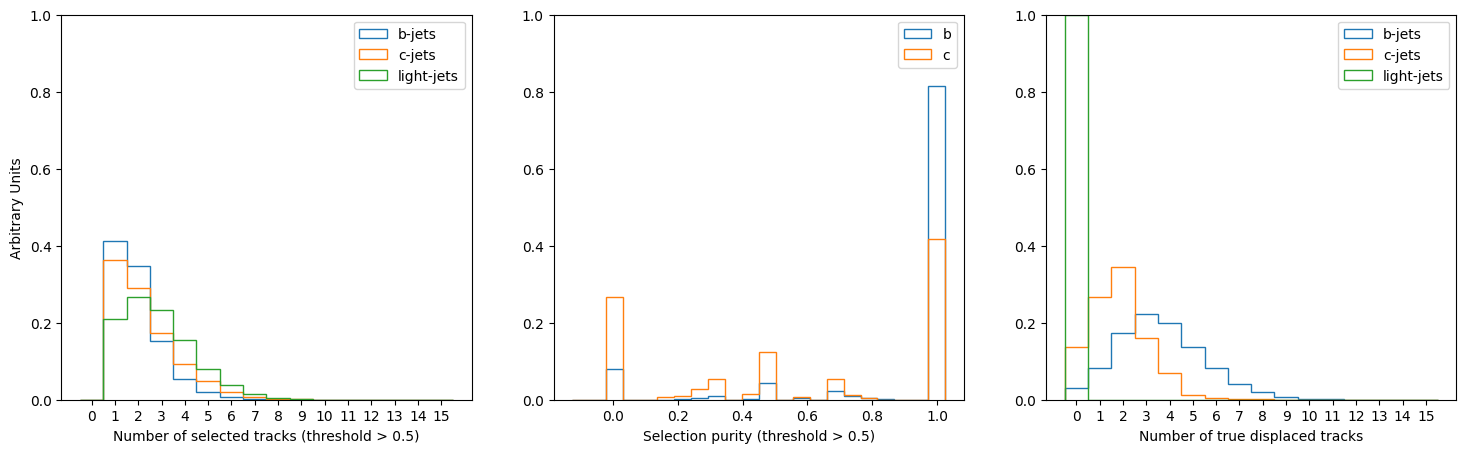

In [28]:
""" Alternative plot illustrating track selection performance, maybe for paper """
threshold = 0.5

# FTAG+ndive model

threshold=0.5
    
fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize=(18,5))
hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_positive, threshold=threshold),
    ax1,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    labels=["b-jets", "c-jets", "light-jets"],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
    plot_avgs=False,
)
ax1.set_ylabel("Arbitrary Units")
ax1.set_xlabel("Number of selected tracks (threshold > 0.5)")
ax1.set_ylim([0.0, 1.0])
ax1.set_xticks(range(16))

hist_options = dict(bins=22, range=(-0.125, 1.025)) # allow nans at -.1, center around 0
ph.graph_output_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    ax2,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"]],
    nan_val=-.1,
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
    plot_avgs=False,
)
ax2.set_xlabel("Selection purity (threshold > 0.5)")
ax2.set_ylim([0.0, 1.0])

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    ph.get_num_true,
    ax3,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    labels=["b-jets", "c-jets", "light-jets"],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
    plot_avgs=False,
)
#ax2.set_ylabel("Arbitrary Units")
ax3.set_xlabel("Number of true displaced tracks")
ax3.set_ylim([0.0, 1.0])
ax3.set_xticks(range(16))


fig.savefig("plots/counts_ftagndive.png")

'done'

'done'

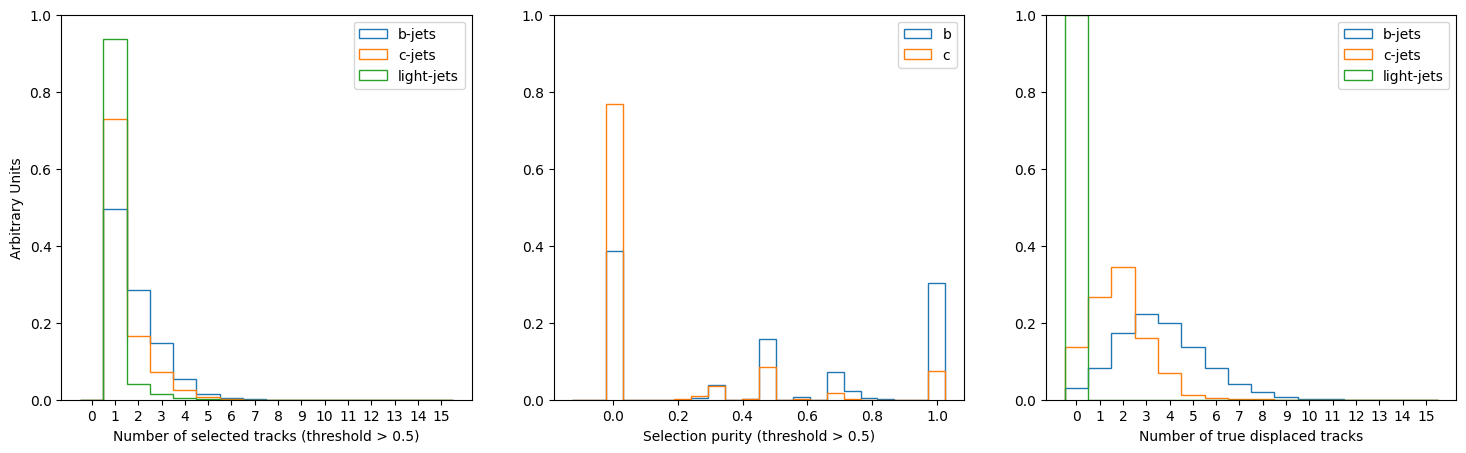

In [29]:
""" Alternative plot illustrating track selection performance, maybe for paper """
threshold = 0.5

# ndive-only model
""" Alternative plot illustrating track selection performance, maybe for paper """
threshold = 0.5

fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize=(18,5))
hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    partial(ph.get_num_positive, threshold=threshold),
    ax1,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    labels=["b-jets", "c-jets", "light-jets"],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
    plot_avgs=False,
)
ax1.set_ylabel("Arbitrary Units")
ax1.set_xlabel("Number of selected tracks (threshold > 0.5)")
ax1.set_ylim([0.0, 1.0])
ax1.set_xticks(range(16))

hist_options = dict(bins=22, range=(-0.125, 1.025)) # allow nans at -.1, center around 0
ph.graph_output_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    ax2,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"]],
    nan_val=-.1,
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
    plot_avgs=False,
)
ax2.set_xlabel("Selection purity (threshold > 0.5)")
ax2.set_ylim([0.0, 1.0])

hist_options = dict(bins=np.arange(-.5,16,1))
ph.graph_output_info(
    ph.get_num_true,
    ax3,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    labels=["b-jets", "c-jets", "light-jets"],
    has_ghost=INCLUDE_GHOST,
    hist_options=hist_options,
    plot_avgs=False,
)
#ax2.set_ylabel("Arbitrary Units")
ax3.set_xlabel("Number of true displaced tracks")
ax3.set_ylim([0.0, 1.0])
ax3.set_xticks(range(16))


fig.savefig("plots/counts_ndiveonly.png")

'done'

num should be shape: min: 0, max: 14
  nan count: 1890


/sdf/home/m/miochoa/Differentiable-Vertexing-Project/diffvert/evaluation/plot_helpers.py:370: RuntimeWarning: Mean of empty slice
  ys = [np.nanmean(out_bin) for out_bin in out_bins]
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


num should be shape: min: 0, max: 14
  nan count: 1890
num should be shape: min: 0, max: 15
  nan count: 8285
num should be shape: min: 0, max: 15
  nan count: 8285


Text(0, 0.5, 'efficiency: true positive / true')

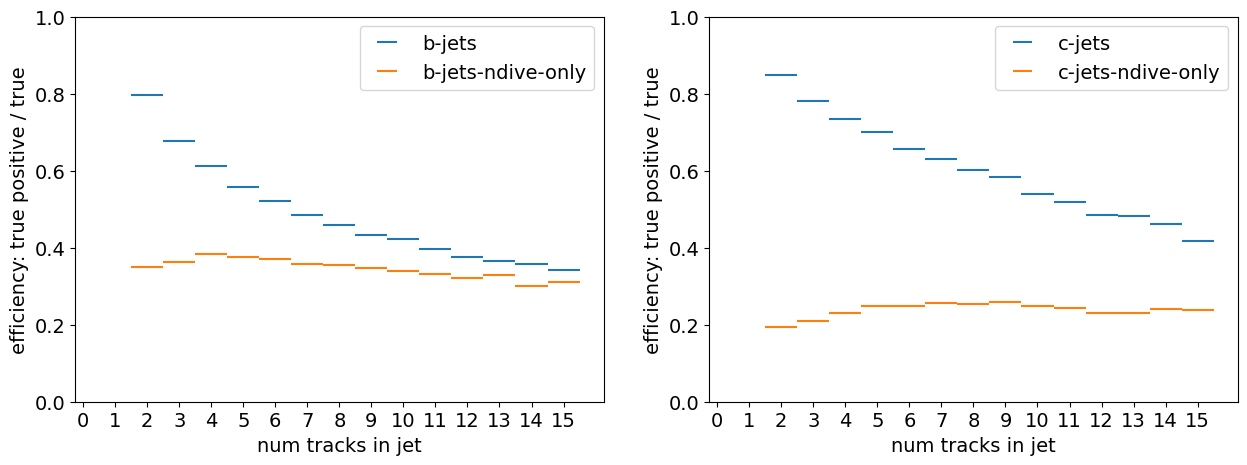

In [48]:
""" Compare ndive-only and full model track-selection efficiency. """
threshold=0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
bins = np.arange(0.5,16,1)
def get_n_trks(inputs):
    """ get number of tracks by jet """ 
    return inputs[:,0,daf.JetData.N_TRACKS]

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_n_trks,
    ax1,
    bins,
    outs_list=[ftag_outs["b_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"]],
    labels=["b-jets"],
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_n_trks,
    ax1,
    bins,
    outs_list=[ndive_outs['b_output_arr']],
    ins_list=[ndive_outs['b_input_arr']],
    colors=['#ff7f0e'],
    labels=["b-jets-ndive-only"],
    drop_y_err=True,
    has_ghost=True,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_n_trks,
    ax2,
    bins,
    outs_list=[ftag_outs["c_output_arr"]],
    ins_list=[ftag_outs["c_input_arr"]],
    labels=["c-jets"],
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_n_trks,
    ax2,
    bins,
    outs_list=[ndive_outs['c_output_arr']],
    ins_list=[ndive_outs['c_input_arr']],
    colors=['#ff7f0e'],
    labels=["c-jets-ndive-only"],
    drop_y_err=True,
    has_ghost=True,
)

ax1.set_xticks(range(16))
ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel("num tracks in jet")
ax1.set_ylabel("efficiency: true positive / true")

ax2.set_xticks(range(16))
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel("num tracks in jet")
ax2.set_ylabel("efficiency: true positive / true")

num should be shape: min: 0, max: 14
  nan count: 1890
num should be shape: min: 0, max: 15
  nan count: 8285


Text(0, 0.5, 'efficiency: true positive / true')

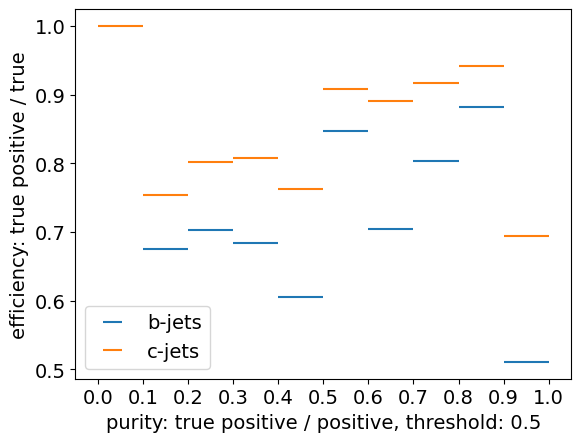

In [20]:
""" Graph effieincy against purity for full model. """
threshold=0.5

fig, ax = plt.subplots(1)
bins = np.linspace(0, 1, 11)
    
ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    ax,
    bins,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"]],
    labels=["b-jets", "c-jets"],
    drop_y_err=True,
    outs_vs_outs=True,
    has_ghost=INCLUDE_GHOST,
)


ax.set_xlabel(f"purity: true positive / positive, threshold: {threshold}")
ax.set_ylabel("efficiency: true positive / true")

num should be shape: min: 0, max: 14
  nan count: 1890
num should be shape: min: 0, max: 14
  nan count: 1890
num should be shape: min: 0, max: 15
  nan count: 8285
num should be shape: min: 0, max: 15
  nan count: 8285


Text(0, 0.5, 'efficiency: true positive / true')

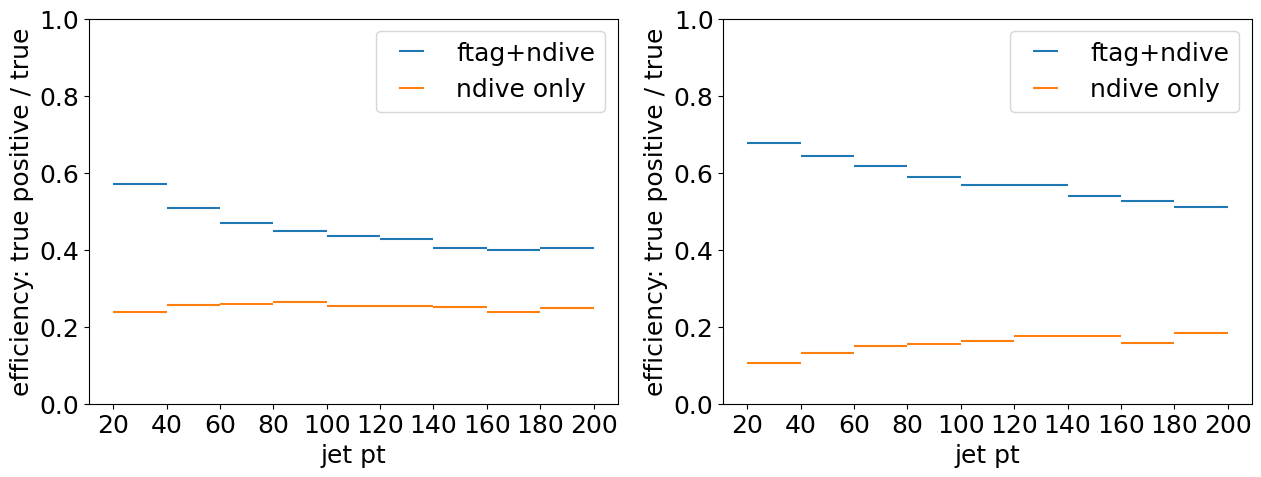

In [21]:
threshold=0.5

plt.rcParams["font.size"]=18
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
bins = np.linspace(20, 200, 10)
def get_jet_pt(inputs):
    """ get pt by jet """ 
    return inputs[:,0,daf.JetData.TRACK_JET_PT]

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_jet_pt,
    ax1,
    bins,
    outs_list=[ftag_outs["b_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"]],
    labels=["ftag+ndive"], #b-jets
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_jet_pt,
    ax1,
    bins,
    outs_list=[ndive_outs["b_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"]],
    labels=["ndive only"], #b-jets
    colors=['#ff7f0e'],
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_jet_pt,
    ax2,
    bins,
    outs_list=[ftag_outs['c_output_arr']],
    ins_list=[ftag_outs['c_input_arr']],
    labels=["ftag+ndive"], #c-jets
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_jet_pt,
    ax2,
    bins,
    outs_list=[ndive_outs['c_output_arr']],
    ins_list=[ndive_outs['c_input_arr']],
    labels=["ndive only"], #c-jets
    colors=['#ff7f0e'],
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel("jet pt")
ax1.set_ylabel("efficiency: true positive / true")

ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel("jet pt")
ax2.set_ylabel("efficiency: true positive / true")

num should be shape: min: 0, max: 14
  nan count: 1890
num should be shape: min: 0, max: 14
  nan count: 1890
num should be shape: min: 0, max: 15
  nan count: 8285
num should be shape: min: 0, max: 15
  nan count: 8285


Text(0, 0.5, 'efficiency: true positive / true')

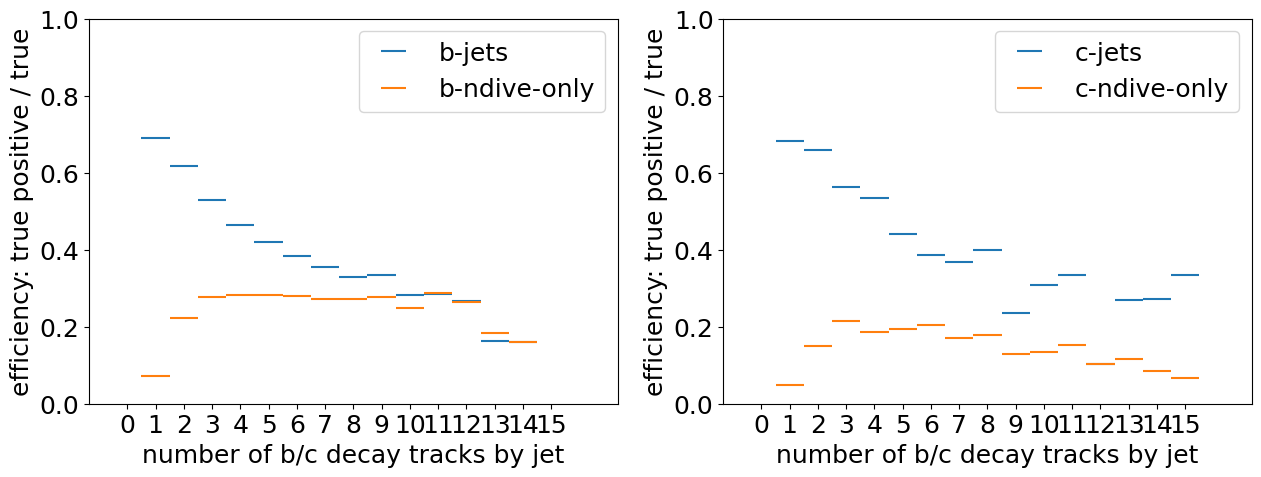

In [22]:
""" Graph track-selection efficiency vs num tracks in decay. """
threshold=0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
bins = np.arange(-.5,17,1)
def get_num_track_in_vertex(inputs):
    """ get number of tracks from decay by jet """ 
    from_decay = np.logical_or(
        inputs[:,:,daf.JetData.TRACK_FROM_B].astype(int)==1,
        inputs[:,:,daf.JetData.TRACK_FROM_C].astype(int)==1,
    )
    return np.sum(from_decay, axis=1)
    
ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_num_track_in_vertex,
    ax1,
    bins,
    outs_list=[ftag_outs["b_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"]],
    labels=["b-jets"],
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_num_track_in_vertex,
    ax1,
    bins,
    outs_list=[ndive_outs["b_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"]],
    labels=["b-ndive-only"],
    colors=['#ff7f0e'],
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_num_track_in_vertex,
    ax2,
    bins,
    outs_list=[ftag_outs["c_output_arr"]],
    ins_list=[ftag_outs["c_input_arr"]],
    labels=["c-jets"],
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_num_track_in_vertex,
    ax2,
    bins,
    outs_list=[ndive_outs["c_output_arr"]],
    ins_list=[ndive_outs["c_input_arr"]],
    labels=["c-ndive-only"],
    colors=['#ff7f0e'],
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

ax1.set_ylim([0.0, 1.0])
ax1.set_xticks(range(16))
ax1.set_xlabel("number of b/c decay tracks by jet")
ax1.set_ylabel("efficiency: true positive / true")

ax2.set_ylim([0.0, 1.0])
ax2.set_xticks(range(16))
ax2.set_xlabel("number of b/c decay tracks by jet")
ax2.set_ylabel("efficiency: true positive / true")

num should be shape: min: 0, max: 14
  nan count: 1890
num should be shape: min: 0, max: 14
  nan count: 1890
num should be shape: min: 0, max: 15
  nan count: 8285
num should be shape: min: 0, max: 15
  nan count: 8285


Text(0, 0.5, 'efficiency: true positive / true')

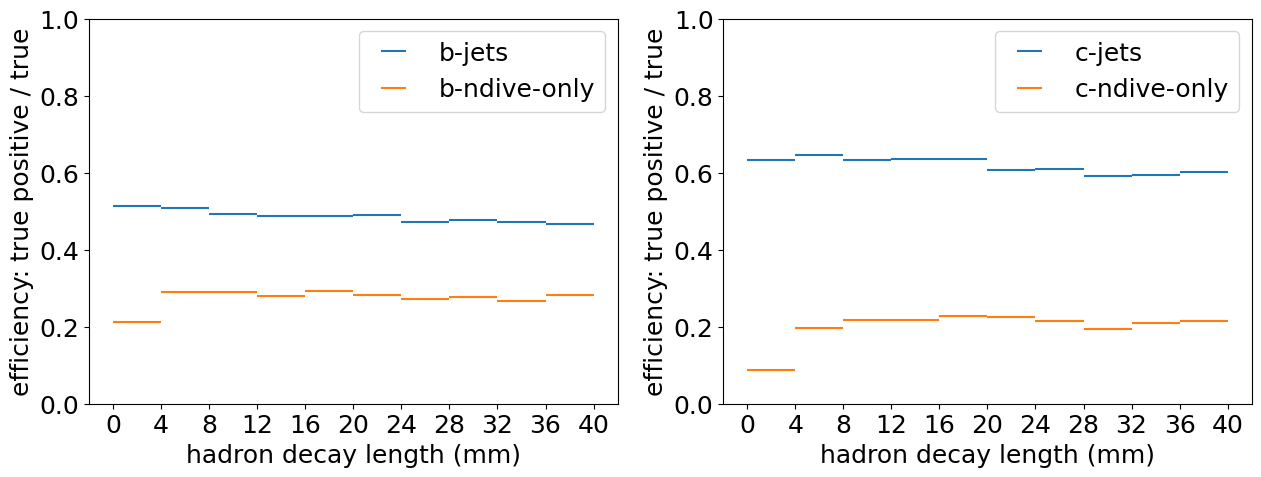

In [23]:
""" Graph track selection efficiency vs hadron decay length. """
threshold=0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
bins = np.linspace(0, 40, 11)

def get_lxy(inputs):
    """ get decay length jet-wise """ 
    return np.sqrt(np.square(inputs[:,0,daf.JetData.HADRON_X])
                   +np.square(inputs[:,0,daf.JetData.HADRON_Y])
                   +np.square(inputs[:,0,daf.JetData.HADRON_Z]))
    
ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_lxy,
    ax1,
    bins,
    outs_list=[ftag_outs["b_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"]],
    labels=["b-jets"],
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_lxy,
    ax1,
    bins,
    outs_list=[ndive_outs["b_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"]],
    labels=["b-ndive-only"],
    colors=['#ff7f0e'],
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_lxy,
    ax2,
    bins,
    outs_list=[ftag_outs["c_output_arr"]],
    ins_list=[ftag_outs["c_input_arr"]],
    labels=["c-jets"],
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_lxy,
    ax2,
    bins,
    outs_list=[ndive_outs["c_output_arr"]],
    ins_list=[ndive_outs["c_input_arr"]],
    labels=["c-ndive-only"],
    colors=['#ff7f0e'],
    drop_y_err=True,
    has_ghost=INCLUDE_GHOST,
)

# ax.hist(get_lxy(b_input_arr), histtype='step', range=(0,40), bins=20)
# ax.hist(get_lxy(c_input_arr), histtype='step', bins=bins)

ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel("hadron decay length (mm)")
ax1.set_ylabel("efficiency: true positive / true")
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel("hadron decay length (mm)")
ax2.set_ylabel("efficiency: true positive / true")

In [24]:
importlib.reload(diffvert.evaluation.plot_helpers)
import diffvert.evaluation.plot_helpers as ph

Text(0, 0.5, 'truth count of tracks from vertex')

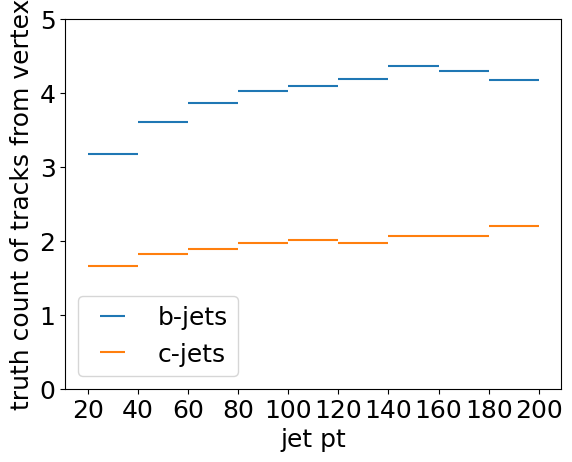

In [25]:
""" Graph count of true decay tracks vs jet-pt. """
fig, ax = plt.subplots(1)
bins = np.linspace(20, 200, 10)
def get_jet_pt(inputs):
    """ get pt by jet """ 
    return inputs[:,0,daf.JetData.TRACK_JET_PT]
ph.graph_output_info_vs_input_info(
    ph.get_num_true,
    get_jet_pt,
    ax,
    bins,
    outs_list=[ftag_outs['b_output_arr']],
    ins_list=[ftag_outs['b_input_arr']],
    labels=["b-jets"],
    drop_y_err=True,
)
ph.graph_output_info_vs_input_info(
    ph.get_num_true,
    get_jet_pt,
    ax,
    bins,
    outs_list=[ftag_outs['c_output_arr']],
    ins_list=[ftag_outs['c_input_arr']],
    labels=["c-jets"],
    colors=["#ff7f0e"],
    drop_y_err=True,
)

ax.set_ylim([0.0, 5.0])
ax.set_xlabel('jet $p_{T}$ [GeV]')
ax.set_ylabel("truth count of tracks from vertex")

Text(0, 0.5, 'number of tracks selected by model')

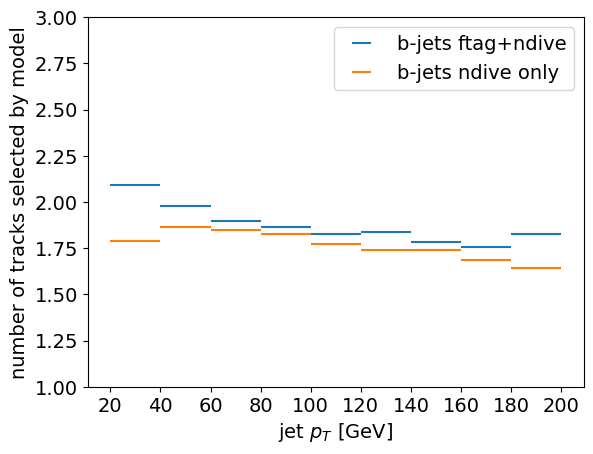

In [33]:
plt.rcParams["font.size"]=14
fig, ax = plt.subplots(1)
bins = np.linspace(20, 200, 10)
def get_jet_pt(inputs):
    """ get pt by jet """ 
    return inputs[:,0,daf.JetData.TRACK_JET_PT]

threshold=0.5
ph.graph_output_info_vs_input_info(
    partial(ph.get_num_positive, threshold=threshold), 
    get_jet_pt, 
    ax, bins, 
    outs_list=[ftag_outs["b_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"]],
    labels=["b-jets ftag+ndive"],
    drop_y_err=True,
    has_ghost=False,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_num_positive, threshold=threshold), 
    get_jet_pt, 
    ax, bins, 
    outs_list=[ndive_outs["b_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"]],
    colors=["#ff7f0e"],
    labels=["b-jets ndive only"],
    drop_y_err=True,
    has_ghost=False,
)

# ax.legend(loc="lower right")
ax.set_ylim([1.0, 3.0])
ax.set_xlabel('jet $p_{T}$ [GeV]')
ax.set_ylabel("number of tracks selected by model")

Text(0, 0.5, 'number of tracks selected by model')

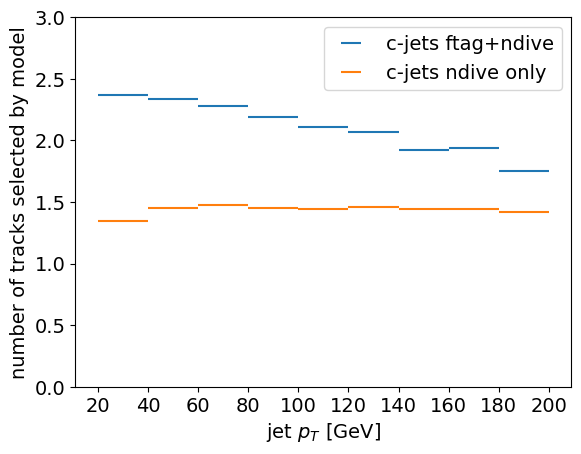

In [34]:
plt.rcParams["font.size"]=14
fig, ax = plt.subplots(1)
bins = np.linspace(20, 200, 10)
def get_jet_pt(inputs):
    """ get pt by jet """ 
    return inputs[:,0,daf.JetData.TRACK_JET_PT]

threshold=0.5
ph.graph_output_info_vs_input_info(
    partial(ph.get_num_positive, threshold=threshold), 
    get_jet_pt, 
    ax, bins, 
    outs_list=[ftag_outs["c_output_arr"]],
    ins_list=[ftag_outs["c_input_arr"]],
    labels=["c-jets ftag+ndive"],
    drop_y_err=True,
    has_ghost=False,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_num_positive, threshold=threshold), 
    get_jet_pt, 
    ax, bins, 
    outs_list=[ndive_outs["c_output_arr"]],
    ins_list=[ndive_outs["c_input_arr"]],
    colors=["#ff7f0e"],
    labels=["c-jets ndive only"],
    drop_y_err=True,
    has_ghost=False,
)

# ax.legend(loc="lower right")
ax.set_ylim([0.0, 3.0])
ax.set_xlabel('jet $p_{T}$ [GeV]')
ax.set_ylabel("number of tracks selected by model")

num should be shape: min: 0, max: 14
  nan count: 1890
num should be shape: min: 0, max: 15
  nan count: 8285


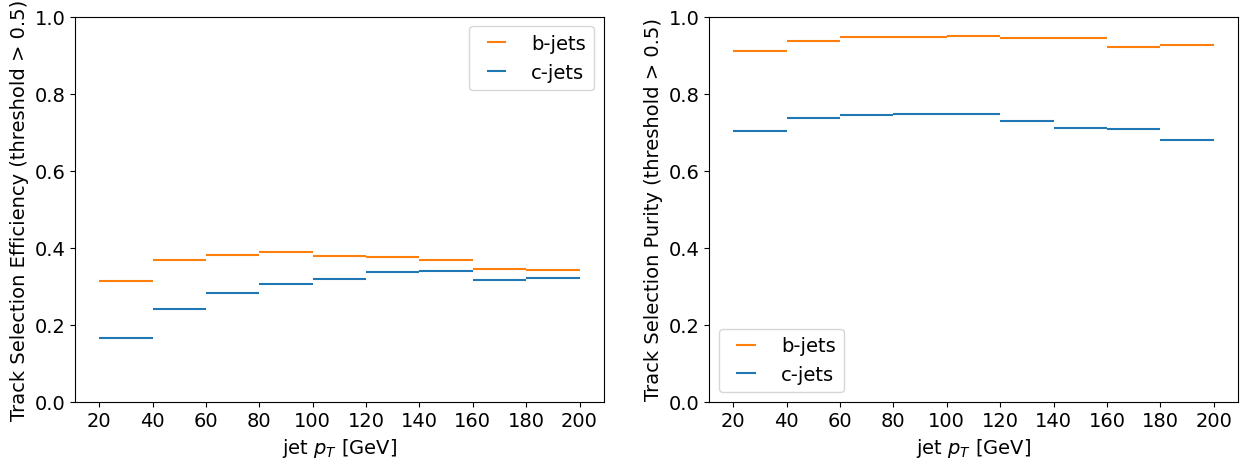

In [49]:
""" Alternative plots for paper """
""" ndive-only, b- and c-jets efficiency and purity as a function of jet pt"""
threshold=0.5
plt.rcParams["font.size"]=14
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
bins = np.linspace(20, 200, 10)
def get_jet_pt(inputs):
    """ get pt by jet """ 
    return inputs[:,0,daf.JetData.TRACK_JET_PT]

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_jet_pt,
    ax1,
    bins,
    outs_list=[ndive_outs['b_output_arr']],
    ins_list=[ndive_outs['b_input_arr']],
    colors=['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=True,
    has_ghost=True,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_jet_pt,
    ax1,
    bins,
    outs_list=[ndive_outs['c_output_arr']],
    ins_list=[ndive_outs['c_input_arr']],
    labels=["c-jets"],
    drop_y_err=True,
    has_ghost=True,
)


ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_jet_pt,
    ax2,
    bins,
    outs_list=[ndive_outs['b_output_arr']],
    ins_list=[ndive_outs['b_input_arr']],
    colors=['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=True,
    has_ghost=True,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_jet_pt,
    ax2,
    bins,
    outs_list=[ndive_outs['c_output_arr']],
    ins_list=[ndive_outs['c_input_arr']],
    labels=["c-jets"],
    drop_y_err=True,
    has_ghost=True,
)


ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel('jet $p_{T}$ [GeV]')
ax1.set_ylabel("Track Selection Efficiency (threshold > 0.5)")

ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel('jet $p_{T}$ [GeV]')
ax2.set_ylabel("Track Selection Purity (threshold > 0.5)")
#plt.savefig("plots/ndive_eff_purity_pt.png")

num should be shape: min: 0, max: 14
  nan count: 1890
num should be shape: min: 0, max: 15
  nan count: 8285


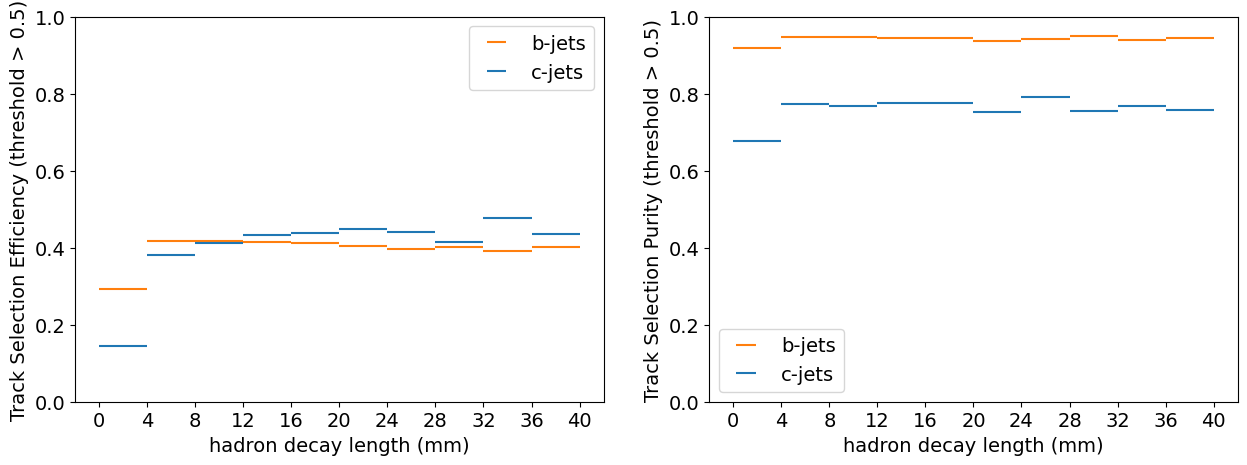

In [47]:
""" Alternative plots for paper """
""" ndive-only, b- and c-jets efficiency and purity as a function of hadron length"""
threshold=0.5
plt.rcParams["font.size"]=14
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

bins = np.linspace(0, 40, 11)

def get_lxy(inputs):
    """ get decay length jet-wise """ 
    return np.sqrt(np.square(inputs[:,0,daf.JetData.HADRON_X])
                   +np.square(inputs[:,0,daf.JetData.HADRON_Y])
                   +np.square(inputs[:,0,daf.JetData.HADRON_Z]))


ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_lxy,
    ax1,
    bins,
    outs_list=[ndive_outs['b_output_arr']],
    ins_list=[ndive_outs['b_input_arr']],
    colors=['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=True,
    has_ghost=True,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_lxy,
    ax1,
    bins,
    outs_list=[ndive_outs['c_output_arr']],
    ins_list=[ndive_outs['c_input_arr']],
    labels=["c-jets"],
    drop_y_err=True,
    has_ghost=True,
)


ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_lxy,
    ax2,
    bins,
    outs_list=[ndive_outs['b_output_arr']],
    ins_list=[ndive_outs['b_input_arr']],
    colors=['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=True,
    has_ghost=True,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_lxy,
    ax2,
    bins,
    outs_list=[ndive_outs['c_output_arr']],
    ins_list=[ndive_outs['c_input_arr']],
    labels=["c-jets"],
    drop_y_err=True,
    has_ghost=True,
)


ax1.set_ylim([0.0, 1.0])
ax1.set_xlabel("hadron decay length (mm)")
ax1.set_ylabel("Track Selection Efficiency (threshold > 0.5)")

ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel("hadron decay length (mm)")
ax2.set_ylabel("Track Selection Purity (threshold > 0.5)")
#plt.savefig("plots/ndive_eff_purity_hadronlength.png")

In [ ]:
importlib.reload(diffvert.evaluation.plot_helpers)
import diffvert.evaluation.plot_helpers as ph


""" New double yaxis plots for paper """
""" ndive-only, b- and c-jets efficiency and purity as a function of track multiplicity"""
threshold=0.5
plt.rcParams["font.size"]=14
fig, ax1 = plt.subplots(1)
bins = np.arange(0.5,16,1)
def get_n_trks(inputs):
    """ get number of tracks by jet """ 
    return inputs[:,0,daf.JetData.N_TRACKS]

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_n_trks,
    ax1,
    bins,
    outs_list=[ndive_outs['b_output_arr']],
    ins_list=[ndive_outs['b_input_arr']],
    colors=["black"],#['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=False,
    has_ghost=True,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_n_trks,
    ax1,
    bins,
    outs_list=[ndive_outs['c_output_arr']],
    ins_list=[ndive_outs['c_input_arr']],
    labels=["c-jets"],
    marker="o",
    colors=["black"],
    drop_y_err=False,
    has_ghost=True,
)

ax2 = ax1.twinx()

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_n_trks,
    ax2,
    bins,
    outs_list=[ndive_outs['b_output_arr']],
    ins_list=[ndive_outs['b_input_arr']],
    colors=["orangered"],#['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=False,
    has_ghost=True,
    add_legend=False,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_n_trks,
    ax2,
    bins,
    outs_list=[ndive_outs['c_output_arr']],
    ins_list=[ndive_outs['c_input_arr']],
    marker="o",
    labels=["c-jets"],
    colors=["orangered"],#['#ff7f0e'],
    drop_y_err=False,
    has_ghost=True,
    add_legend=False,
)


ax1.set_xticks(range(16))
ax1.set_xlabel("Track Multiplicity")

ax1.set_ylim([0.0, 1.2])
ax1.set_yticks(np.linspace(0,1,6))
ax1.set_ylabel("Efficiency")#, color="black")
#ax1.tick_params(axis='y', labelcolor="black")
ax2.set_ylabel("Purity", color="red")
ax2.tick_params(axis='y', labelcolor="orangered")
ax2.set_ylim([0.0, 1.2])
ax2.set_yticks(np.linspace(0,1,6))
plt.text(0.35, 1.1, 'NDIVE', dict(size=13))

fig.tight_layout()
plt.savefig("plots/ndive_eff_purity_ntrack.png")

num should be shape: min: 0, max: 14
  nan count: 1890
 ... and now calculating errors.
num should be shape: min: 0, max: 15
  nan count: 8285
 ... and now calculating errors.
 ... and now calculating errors.
 ... and now calculating errors.


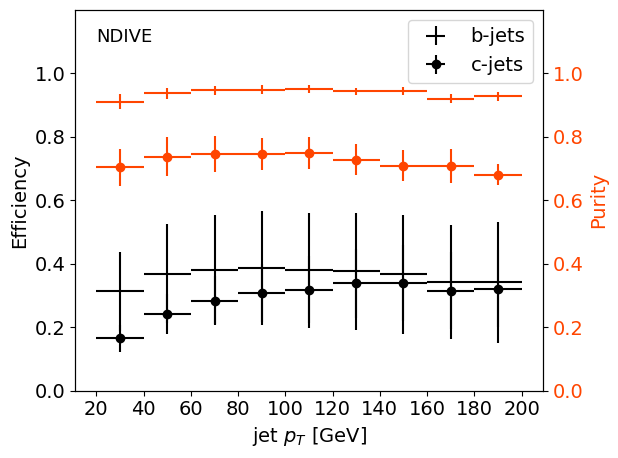

In [84]:
""" New double yaxis plots for paper """
""" ndive-only, b- and c-jets efficiency and purity as a function of track multiplicity"""
threshold=0.5
plt.rcParams["font.size"]=14
fig, ax1 = plt.subplots(1)

bins = np.linspace(20, 200, 10)
def get_jet_pt(inputs):
    """ get pt by jet """ 
    return inputs[:,0,daf.JetData.TRACK_JET_PT]

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_jet_pt,
    ax1,
    bins,
    outs_list=[ndive_outs['b_output_arr']],
    ins_list=[ndive_outs['b_input_arr']],
    colors=["black"],#['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=False,
    has_ghost=True,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_jet_pt,
    ax1,
    bins,
    outs_list=[ndive_outs['c_output_arr']],
    ins_list=[ndive_outs['c_input_arr']],
    labels=["c-jets"],
    marker="o",
    colors=["black"],
    drop_y_err=False,
    has_ghost=True,
)

ax2 = ax1.twinx()

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_jet_pt,
    ax2,
    bins,
    outs_list=[ndive_outs['b_output_arr']],
    ins_list=[ndive_outs['b_input_arr']],
    colors=["orangered"],#['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=False,
    has_ghost=True,
    add_legend=False,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_jet_pt,
    ax2,
    bins,
    outs_list=[ndive_outs['c_output_arr']],
    ins_list=[ndive_outs['c_input_arr']],
    marker="o",
    labels=["c-jets"],
    colors=["orangered"],#['#ff7f0e'],
    drop_y_err=False,
    has_ghost=True,
    add_legend=False,
)


ax1.set_xlabel('jet $p_{T}$ [GeV]')

ax1.set_ylim([0.0, 1.2])
ax1.set_yticks(np.linspace(0,1,6))
ax1.set_ylabel("Efficiency")#, color="black")
#ax1.tick_params(axis='y', labelcolor="black")
ax2.set_ylabel("Purity", color="orangered")
ax2.tick_params(axis='y', labelcolor="orangered")
ax2.set_ylim([0.0, 1.2])
ax2.set_yticks(np.linspace(0,1,6))
plt.text(20, 1.1, 'NDIVE', dict(size=13))


fig.tight_layout()
plt.savefig("plots/ndive_eff_purity_pt.png")

num should be shape: min: 0, max: 14
  nan count: 1890
 ... and now calculating errors.
num should be shape: min: 0, max: 15
  nan count: 8285
 ... and now calculating errors.
 ... and now calculating errors.
 ... and now calculating errors.


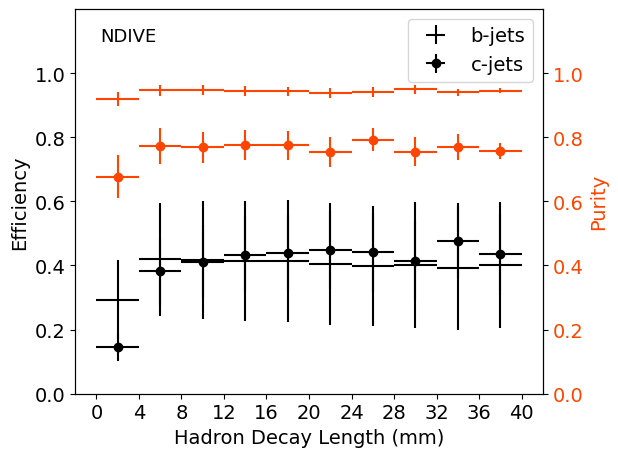

In [85]:
""" New double yaxis plots for paper """
""" ndive-only, b- and c-jets efficiency and purity as a function of track multiplicity"""
threshold=0.5
plt.rcParams["font.size"]=14
fig, ax1 = plt.subplots(1)


bins = np.linspace(0, 40, 11)

def get_lxy(inputs):
    """ get decay length jet-wise """ 
    return np.sqrt(np.square(inputs[:,0,daf.JetData.HADRON_X])
                   +np.square(inputs[:,0,daf.JetData.HADRON_Y])
                   +np.square(inputs[:,0,daf.JetData.HADRON_Z]))

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_lxy,
    ax1,
    bins,
    outs_list=[ndive_outs['b_output_arr']],
    ins_list=[ndive_outs['b_input_arr']],
    colors=["black"],#['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=False,
    has_ghost=True,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_lxy,
    ax1,
    bins,
    outs_list=[ndive_outs['c_output_arr']],
    ins_list=[ndive_outs['c_input_arr']],
    labels=["c-jets"],
    marker="o",
    colors=["black"],
    drop_y_err=False,
    has_ghost=True,
)

ax2 = ax1.twinx()

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_lxy,
    ax2,
    bins,
    outs_list=[ndive_outs['b_output_arr']],
    ins_list=[ndive_outs['b_input_arr']],
    colors=["orangered"],#['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=False,
    has_ghost=True,
    add_legend=False,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_lxy,
    ax2,
    bins,
    outs_list=[ndive_outs['c_output_arr']],
    ins_list=[ndive_outs['c_input_arr']],
    marker="o",
    labels=["c-jets"],
    colors=["orangered"],#['#ff7f0e'],
    drop_y_err=False,
    has_ghost=True,
    add_legend=False,
)


ax1.set_xlabel("Hadron Decay Length (mm)")

ax1.set_ylim([0.0, 1.2])
ax1.set_yticks(np.linspace(0,1,6))
ax1.set_ylabel("Efficiency")#, color="black")
#ax1.tick_params(axis='y', labelcolor="black")
ax2.set_ylabel("Purity", color="orangered")
ax2.tick_params(axis='y', labelcolor="orangered")
ax2.set_ylim([0.0, 1.2])
ax2.set_yticks(np.linspace(0,1,6))
plt.text(0.35, 1.1, 'NDIVE', dict(size=13))


fig.tight_layout()
plt.savefig("plots/ndive_eff_purity_hadronlength.png")

num should be shape: min: 0, max: 14
  nan count: 1890
 ... and now calculating errors.
num should be shape: min: 0, max: 15
  nan count: 8285
 ... and now calculating errors.
 ... and now calculating errors.
 ... and now calculating errors.


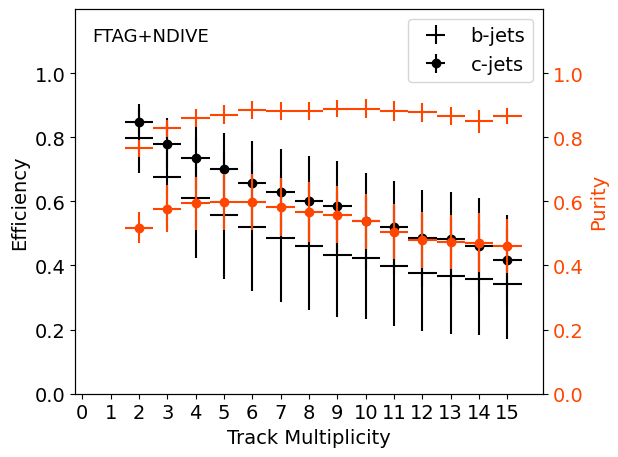

In [86]:
""" New double yaxis plots for paper """
""" ndive-only, b- and c-jets efficiency and purity as a function of track multiplicity"""
threshold=0.5
plt.rcParams["font.size"]=14
fig, ax1 = plt.subplots(1)
bins = np.arange(0.5,16,1)
def get_n_trks(inputs):
    """ get number of tracks by jet """ 
    return inputs[:,0,daf.JetData.N_TRACKS]

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_n_trks,
    ax1,
    bins,
    outs_list=[ftag_outs['b_output_arr']],
    ins_list=[ftag_outs['b_input_arr']],
    colors=["black"],#['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=False,
    has_ghost=False,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_n_trks,
    ax1,
    bins,
    outs_list=[ftag_outs['c_output_arr']],
    ins_list=[ftag_outs['c_input_arr']],
    labels=["c-jets"],
    marker="o",
    colors=["black"],
    drop_y_err=False,
    has_ghost=False,
)

ax2 = ax1.twinx()

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_n_trks,
    ax2,
    bins,
    outs_list=[ftag_outs['b_output_arr']],
    ins_list=[ftag_outs['b_input_arr']],
    colors=["orangered"],#['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=False,
    has_ghost=False,
    add_legend=False,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_n_trks,
    ax2,
    bins,
    outs_list=[ftag_outs['c_output_arr']],
    ins_list=[ftag_outs['c_input_arr']],
    marker="o",
    labels=["c-jets"],
    colors=["orangered"],#['#ff7f0e'],
    drop_y_err=False,
    has_ghost=False,
    add_legend=False,
)


ax1.set_xticks(range(16))
ax1.set_xlabel("Track Multiplicity")

ax1.set_ylim([0.0, 1.2])
ax1.set_yticks(np.linspace(0,1,6))
ax1.set_ylabel("Efficiency")#, color="black")
#ax1.tick_params(axis='y', labelcolor="black")
ax2.set_ylabel("Purity", color="orangered")
ax2.tick_params(axis='y', labelcolor="orangered")
ax2.set_ylim([0.0, 1.2])
ax2.set_yticks(np.linspace(0,1,6))
plt.text(0.35, 1.1, 'FTAG+NDIVE', dict(size=13))

fig.tight_layout()
plt.savefig("plots/ftagndive_eff_purity_ntrack.png")

num should be shape: min: 0, max: 14
  nan count: 1890
 ... and now calculating errors.
num should be shape: min: 0, max: 15
  nan count: 8285
 ... and now calculating errors.
 ... and now calculating errors.
 ... and now calculating errors.


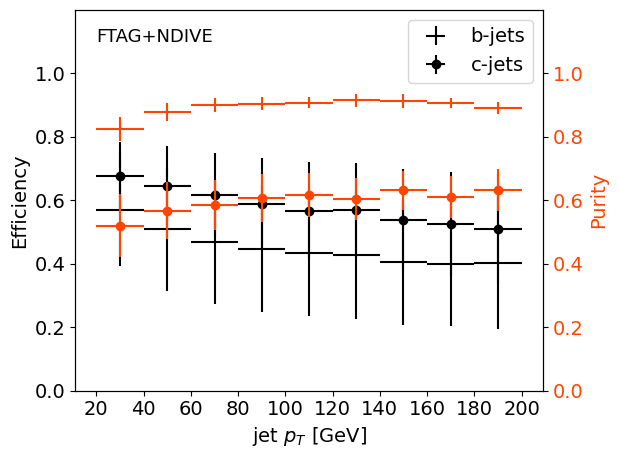

In [87]:
""" New double yaxis plots for paper """
""" ndive-only, b- and c-jets efficiency and purity as a function of track multiplicity"""
threshold=0.5
plt.rcParams["font.size"]=14
fig, ax1 = plt.subplots(1)

bins = np.linspace(20, 200, 10)
def get_jet_pt(inputs):
    """ get pt by jet """ 
    return inputs[:,0,daf.JetData.TRACK_JET_PT]

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_jet_pt,
    ax1,
    bins,
    outs_list=[ftag_outs['b_output_arr']],
    ins_list=[ftag_outs['b_input_arr']],
    colors=["black"],#['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=False,
    has_ghost=False,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_jet_pt,
    ax1,
    bins,
    outs_list=[ftag_outs['c_output_arr']],
    ins_list=[ftag_outs['c_input_arr']],
    labels=["c-jets"],
    marker="o",
    colors=["black"],
    drop_y_err=False,
    has_ghost=False,
)

ax2 = ax1.twinx()

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_jet_pt,
    ax2,
    bins,
    outs_list=[ftag_outs['b_output_arr']],
    ins_list=[ftag_outs['b_input_arr']],
    colors=["orangered"],#['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=False,
    has_ghost=False,
    add_legend=False,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_jet_pt,
    ax2,
    bins,
    outs_list=[ftag_outs['c_output_arr']],
    ins_list=[ftag_outs['c_input_arr']],
    marker="o",
    labels=["c-jets"],
    colors=["orangered"],#['#ff7f0e'],
    drop_y_err=False,
    has_ghost=False,
    add_legend=False,
)


ax1.set_xlabel('jet $p_{T}$ [GeV]')

ax1.set_ylim([0.0, 1.2])
ax1.set_yticks(np.linspace(0,1,6))
ax1.set_ylabel("Efficiency")#, color="black")
#ax1.tick_params(axis='y', labelcolor="black")
ax2.set_ylabel("Purity", color="orangered")
ax2.tick_params(axis='y', labelcolor="orangered")
ax2.set_ylim([0.0, 1.2])
ax2.set_yticks(np.linspace(0,1,6))
plt.text(20, 1.1, 'FTAG+NDIVE', dict(size=13))


fig.tight_layout()
plt.savefig("plots/ftagndive_eff_purity_pt.png")

num should be shape: min: 0, max: 14
  nan count: 1890
 ... and now calculating errors.
num should be shape: min: 0, max: 15
  nan count: 8285
 ... and now calculating errors.
 ... and now calculating errors.
 ... and now calculating errors.


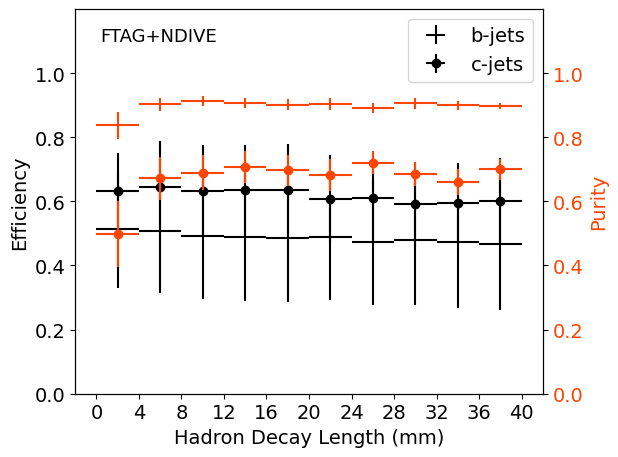

In [88]:
""" New double yaxis plots for paper """
""" ndive-only, b- and c-jets efficiency and purity as a function of track multiplicity"""
threshold=0.5
plt.rcParams["font.size"]=14
fig, ax1 = plt.subplots(1)


bins = np.linspace(0, 40, 11)

def get_lxy(inputs):
    """ get decay length jet-wise """ 
    return np.sqrt(np.square(inputs[:,0,daf.JetData.HADRON_X])
                   +np.square(inputs[:,0,daf.JetData.HADRON_Y])
                   +np.square(inputs[:,0,daf.JetData.HADRON_Z]))

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_lxy,
    ax1,
    bins,
    outs_list=[ftag_outs['b_output_arr']],
    ins_list=[ftag_outs['b_input_arr']],
    colors=["black"],#['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=False,
    has_ghost=False,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_true, threshold=threshold),
    get_lxy,
    ax1,
    bins,
    outs_list=[ftag_outs['c_output_arr']],
    ins_list=[ftag_outs['c_input_arr']],
    labels=["c-jets"],
    marker="o",
    colors=["black"],
    drop_y_err=False,
    has_ghost=False,
)

ax2 = ax1.twinx()

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_lxy,
    ax2,
    bins,
    outs_list=[ftag_outs['b_output_arr']],
    ins_list=[ftag_outs['b_input_arr']],
    colors=["orangered"],#['#ff7f0e'],
    labels=["b-jets"],
    drop_y_err=False,
    has_ghost=False,
    add_legend=False,
)

ph.graph_output_info_vs_input_info(
    partial(ph.get_ratio_true_pos_pos, threshold=threshold),
    get_lxy,
    ax2,
    bins,
    outs_list=[ftag_outs['c_output_arr']],
    ins_list=[ftag_outs['c_input_arr']],
    marker="o",
    labels=["c-jets"],
    colors=["orangered"],#['#ff7f0e'],
    drop_y_err=False,
    has_ghost=False,
    add_legend=False,
)


ax1.set_xlabel("Hadron Decay Length (mm)")

ax1.set_ylim([0.0, 1.2])
ax1.set_yticks(np.linspace(0,1,6))
ax1.set_ylabel("Efficiency")#, color="black")
#ax1.tick_params(axis='y', labelcolor="black")
ax2.set_ylabel("Purity", color="orangered")
ax2.tick_params(axis='y', labelcolor="orangered")
ax2.set_ylim([0.0, 1.2])
ax2.set_yticks(np.linspace(0,1,6))
plt.text(0.35, 1.1, 'FTAG+NDIVE', dict(size=13))


fig.tight_layout()
plt.savefig("plots/ftagndive_eff_purity_hadronlength.png")

### Look at vertexing performance (functions of true vs porangeredicted vertex)

In [50]:
importlib.reload(diffvert.evaluation.plot_helpers)
import diffvert.evaluation.plot_helpers as ph

Text(0, 0.5, 'Mean euclidean distance (mm)')

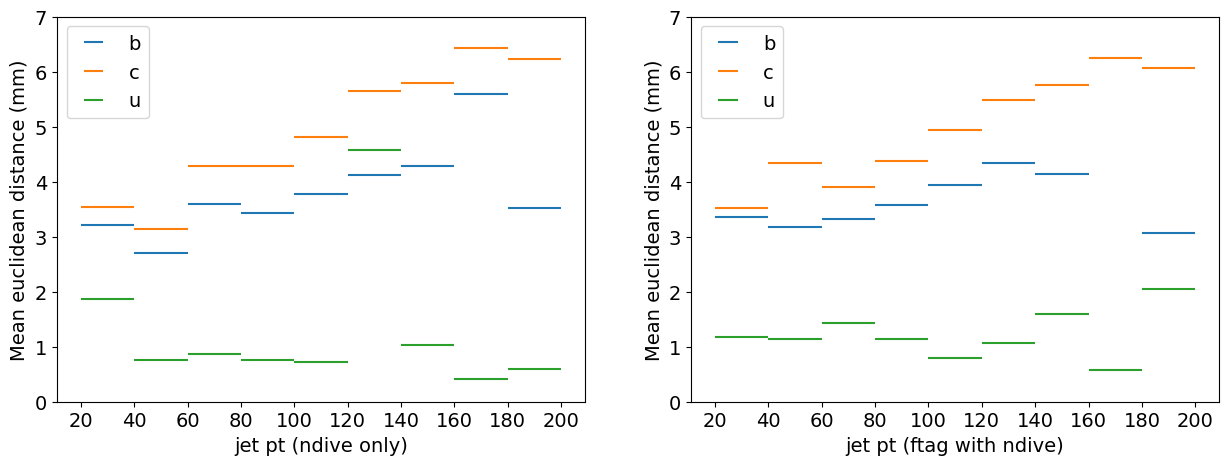

In [36]:
""" Plot mean euclidean distance vs pt. """
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
bins = np.linspace(20, 200, 10)

def get_jet_pt(inputs):
    """ get pt by jet """ 
    return inputs[:,0,daf.JetData.TRACK_JET_PT]

ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean, 
    get_jet_pt,
    ax1, bins,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    drop_y_err=True,
)

ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean, 
    get_jet_pt,
    ax2, bins,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    drop_y_err=True,
)

ax1.set_ylim([0, 7])
ax1.set_xlabel("jet pt (ndive only)")
ax1.set_ylabel("Mean euclidean distance (mm)")
ax2.set_ylim([0, 7])
ax2.set_xlabel("jet pt (ftag with ndive)")
ax2.set_ylabel("Mean euclidean distance (mm)")

Text(0, 0.5, 'Mean normalized euclidean distance')

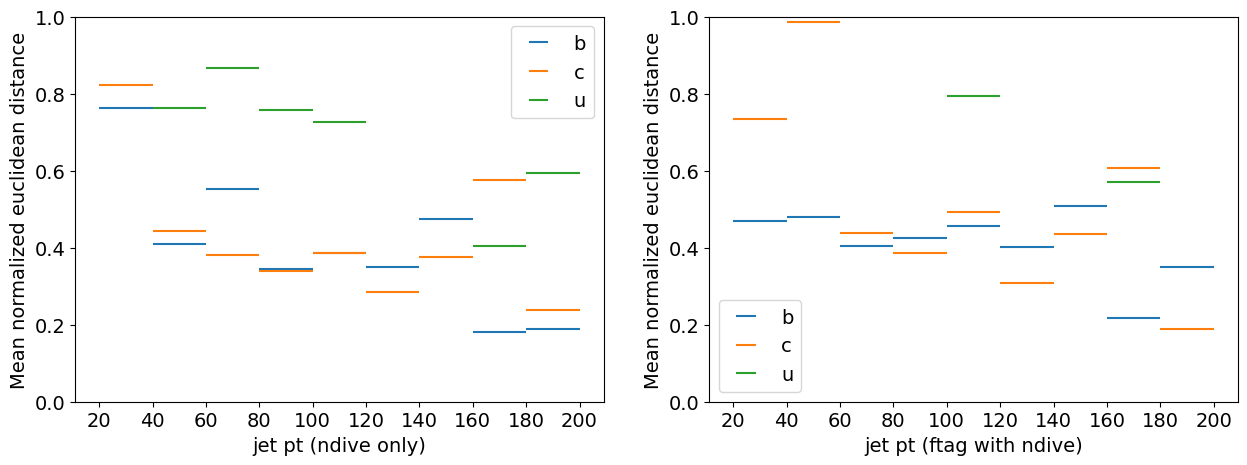

In [37]:
""" Plot mean normalized euclidean distance vs pt. """
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
bins = np.linspace(20, 200, 10)

def get_jet_pt(inputs):
    """ get pt by jet """ 
    return inputs[:,0,daf.JetData.TRACK_JET_PT]

ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean_normalized, 
    get_jet_pt,
    ax1, bins,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    drop_y_err=True,
)

ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean_normalized, 
    get_jet_pt,
    ax2, bins,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    drop_y_err=True,
)

ax1.set_ylim([0, 1.0])
ax1.set_xlabel("jet pt (ndive only)")
ax1.set_ylabel("Mean normalized euclidean distance")
ax2.set_ylim([0, 1.0])
ax2.set_xlabel("jet pt (ftag with ndive)")
ax2.set_ylabel("Mean normalized euclidean distance")

Text(0, 0.5, '${v}_{fit} - {v}_{true}$ (mm)')

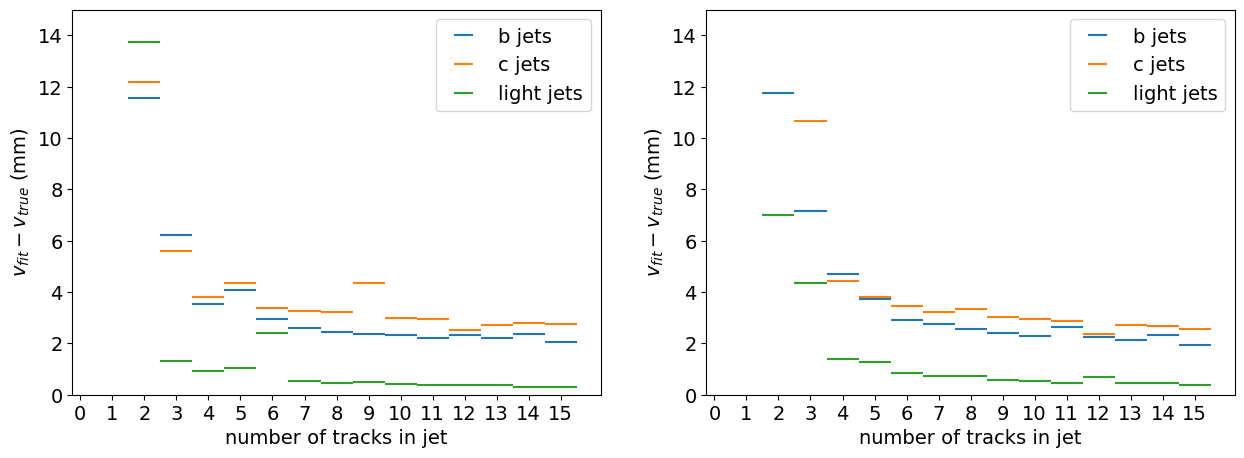

In [38]:
""" Plot mean euclidean distance vs num tracks in jet. """
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
bins = np.arange(0.5,16,1)
def get_n_trks(inputs):
    """ get number of tracks by jet """ 
    return inputs[:,0,daf.JetData.N_TRACKS]

ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean, 
    get_n_trks,
    ax1, bins,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    drop_y_err=True,
    labels=["b jets", "c jets", "light jets"],
)

ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean, 
    get_n_trks,
    ax2, bins,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    labels=["b jets", "c jets", "light jets"],
    drop_y_err=True,
)

plt.rcParams["font.size"]=16
ax1.set_ylim([0, 15])
ax1.set_xticks(range(16))
ax1.set_xlabel("number of tracks in jet")
ax1.set_ylabel("${v}_{fit} - {v}_{true}$ (mm)")
ax2.set_ylim([0, 15])
ax2.set_xticks(range(16))
ax2.set_xlabel("number of tracks in jet")
ax2.set_ylabel("${v}_{fit} - {v}_{true}$ (mm)")


Text(0, 0.5, 'Mean normalized euclidean distance')

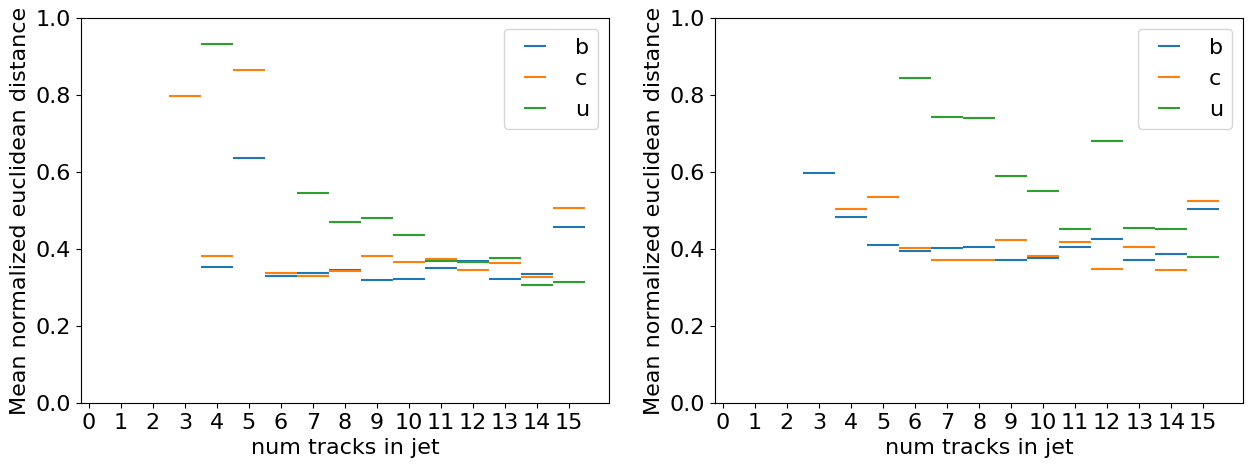

In [39]:
""" Plot mean normalized euclidean distance vs num tracks in jet. """
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
bins = np.arange(0.5,16,1)
def get_n_trks(inputs):
    """ get number of tracks by jet """ 
    return inputs[:,0,daf.JetData.N_TRACKS]

ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean_normalized, 
    get_n_trks,
    ax1, bins,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    drop_y_err=True,
)

ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean_normalized, 
    get_n_trks,
    ax2, bins,
    outs_list=[ftag_outs["b_output_arr"], ftag_outs["c_output_arr"], ftag_outs["u_output_arr"]],
    ins_list=[ftag_outs["b_input_arr"], ftag_outs["c_input_arr"], ftag_outs["u_input_arr"]],
    drop_y_err=True,
)

ax1.set_xticks(range(16))
ax1.set_ylim([0, 1.0])
ax1.set_xlabel("num tracks in jet")
ax1.set_ylabel("Mean normalized euclidean distance")
ax2.set_xticks(range(16))
ax2.set_ylim([0, 1.0])
ax2.set_xlabel("num tracks in jet")
ax2.set_ylabel("Mean normalized euclidean distance")

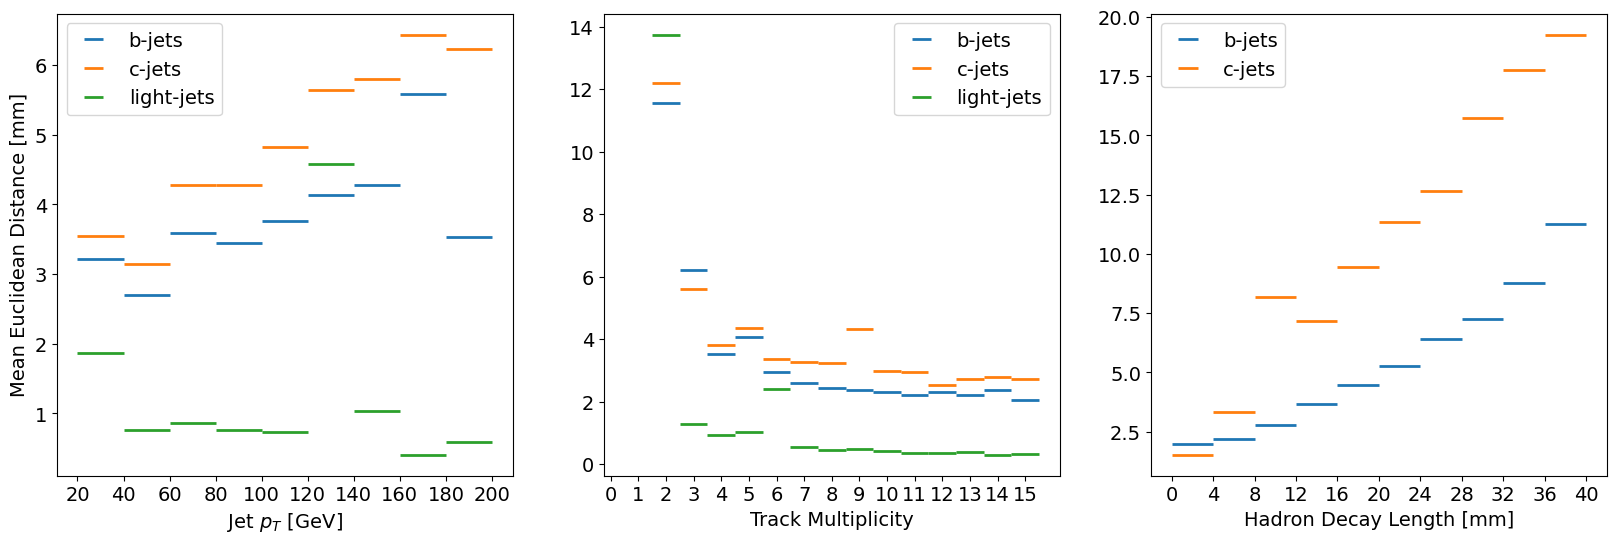

In [86]:
""" Alternative plots for paper """
""" MED (not normalized) for b,c, and light jets as a function of jet pt, track multiplicity and hadron decay length """


plt.rcParams["font.size"]=14
plt.rcParams["lines.linewidth"]=2
fig, (ax2, ax1, ax3) = plt.subplots(1, 3, figsize=(20,6))


bins = np.linspace(20, 200, 10)

def get_jet_pt(inputs):
    """ get pt by jet """ 
    return inputs[:,0,daf.JetData.TRACK_JET_PT]

ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean, 
    get_jet_pt,
    ax2, bins,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    labels=["b-jets", "c-jets", "light-jets"],
    drop_y_err=True,
)

#ax2.set_ylim([0, 1.0])
ax2.set_xlabel("Jet $p_{T}$ [GeV]")
ax2.set_ylabel("Mean Euclidean Distance [mm]")
bins = np.arange(0.5,16,1)

def get_n_trks(inputs):
    """ get number of tracks by jet """ 
    return inputs[:,0,daf.JetData.N_TRACKS]

ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean, 
    get_n_trks,
    ax1, bins,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    labels=["b-jets", "c-jets", "light-jets"],
    drop_y_err=True,
)

ax1.set_xticks(range(16))
#ax1.set_ylim([0, 1.0])
ax1.set_xlabel("Track Multiplicity")


bins = np.linspace(0, 40, 11)

def get_lxy(inputs):
    """ get decay length jet-wise """ 
    return np.sqrt(np.square(inputs[:,0,daf.JetData.HADRON_X])
                   +np.square(inputs[:,0,daf.JetData.HADRON_Y])
                   +np.square(inputs[:,0,daf.JetData.HADRON_Z]))

ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean, 
    get_lxy,
    ax3, bins,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"]],
    labels=["b-jets", "c-jets"],
    drop_y_err=True,
)

#ax3.set_xticks(range(16))
#ax1.set_ylim([0, 1.0])
ax3.set_xlabel("Hadron Decay Length [mm]")
plt.savefig("plots/ndive_med.png")


In [90]:
np.linspace(20, 200, 10)

array([ 20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.])

In [99]:
np.arange(0.5,16,2)

array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5])

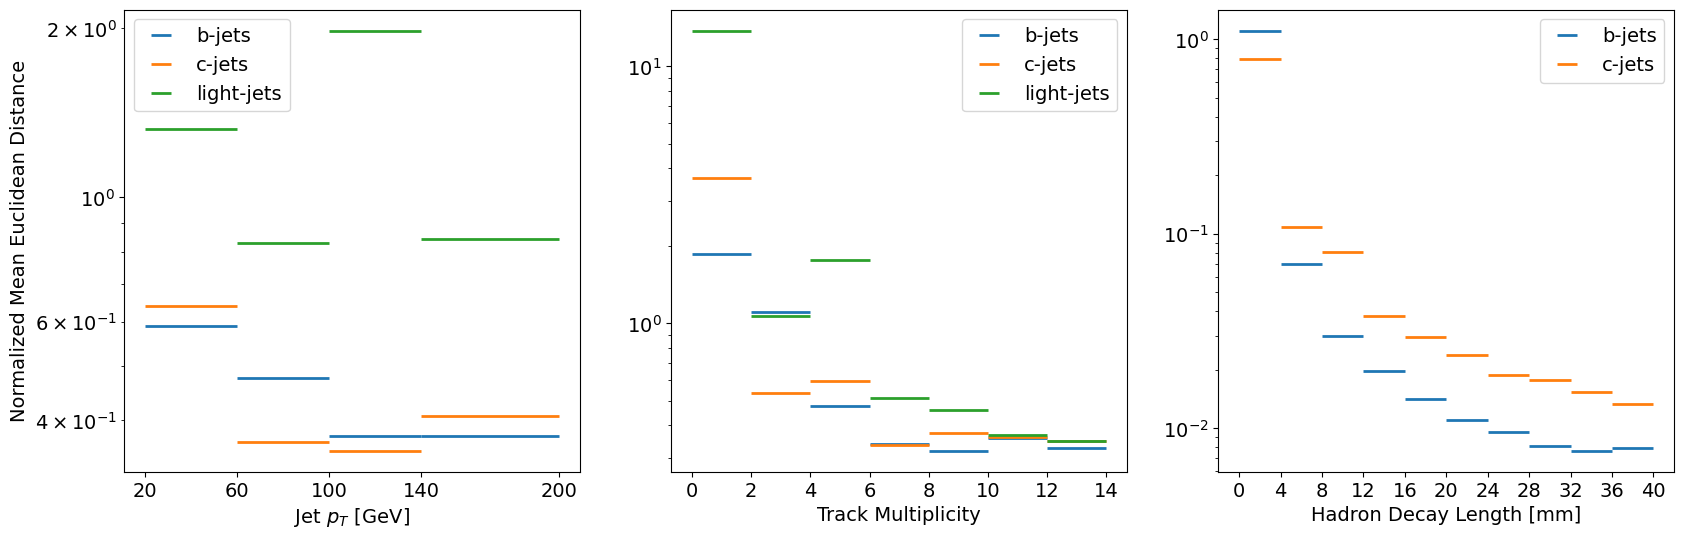

In [104]:
""" Alternative plots for paper """
""" MED normalized for b,c, and light jets as a function of jet pt, track multiplicity and hadron decay length """


plt.rcParams["font.size"]=14
plt.rcParams["lines.linewidth"]=2
fig, (ax2, ax1, ax3) = plt.subplots(1, 3, figsize=(20,6))


#bins = np.linspace(20, 200, 10)
#bins = np.linspace(20, 200, 10)
bins = np.array([ 20.,  60., 100., 140., 200.])

def get_jet_pt(inputs):
    """ get pt by jet """ 
    return inputs[:,0,daf.JetData.TRACK_JET_PT]

test = ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean_normalized, 
    get_jet_pt,
    ax2, bins,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    labels=["b-jets", "c-jets", "light-jets"],
    drop_y_err=True,
)

ax2.set_yscale("log")
ax2.set_xlabel("Jet $p_{T}$ [GeV]")
ax2.set_ylabel("Normalized Mean Euclidean Distance")


#bins = np.arange(0.5,16,1)
bins = np.arange(0,16,2)

def get_n_trks(inputs):
    """ get number of tracks by jet """ 
    return inputs[:,0,daf.JetData.N_TRACKS]

ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean_normalized, 
    get_n_trks,
    ax1, bins,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"], ndive_outs["u_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"], ndive_outs["u_input_arr"]],
    labels=["b-jets", "c-jets", "light-jets"],
    drop_y_err=True,
)

ax1.set_yscale("log")
ax1.set_xticks(range(0,16,2))
ax1.set_xlabel("Track Multiplicity")


bins = np.linspace(0, 40, 11)

def get_lxy(inputs):
    """ get decay length jet-wise """ 
    return np.sqrt(np.square(inputs[:,0,daf.JetData.HADRON_X])
                   +np.square(inputs[:,0,daf.JetData.HADRON_Y])
                   +np.square(inputs[:,0,daf.JetData.HADRON_Z]))

ph.graph_output_info_vs_input_info(
    ph.get_vertex_error_euclidean_normalized, 
    get_lxy,
    ax3, bins,
    outs_list=[ndive_outs["b_output_arr"], ndive_outs["c_output_arr"]],
    ins_list=[ndive_outs["b_input_arr"], ndive_outs["c_input_arr"]],
    labels=["b-jets", "c-jets"],
    drop_y_err=True,
)

#ax3.set_ylim([1e-3, 1.0])
ax3.set_yscale("log")
ax3.set_xlabel("Hadron Decay Length [mm]")
plt.savefig("plots/ndive_med_norm.png")

### 2D histogram of vertex prediction performance

In [101]:
from matplotlib import colors

def make_2dhist_vertex_prediction(x_ax, y_ax, z_ax, outputs, inputs):
    """ Create 2d histogram of predicted coordinate vs true coordinate for x, y, and z."""

    bins = [50,50]
    range = [[-50, 50], [-50, 50]]

    if x_ax is not None: x_ax.hist2d(inputs[:,0,daf.JetData.HADRON_X], outputs[:,daf.JetPrediction.VERTEX_X], bins=bins, range=range, norm=colors.LogNorm())
    if y_ax is not None: y_ax.hist2d(inputs[:,0,daf.JetData.HADRON_Y], outputs[:,daf.JetPrediction.VERTEX_Y], bins=bins, range=range, norm=colors.LogNorm())
    if z_ax is not None: z_ax.hist2d(inputs[:,0,daf.JetData.HADRON_Z], outputs[:,daf.JetPrediction.VERTEX_Z], bins=bins, range=range, norm=colors.LogNorm())

    for ax, dim in zip([x_ax, y_ax, z_ax], ['X', 'Y', 'Z']):
        if ax is None: continue
        ax.set_xlabel(f'${dim}_{{true}}$ [mm]', fontsize = 14)
        ax.set_ylabel(f'${dim}_{{pred}}$ [mm]', fontsize = 14)


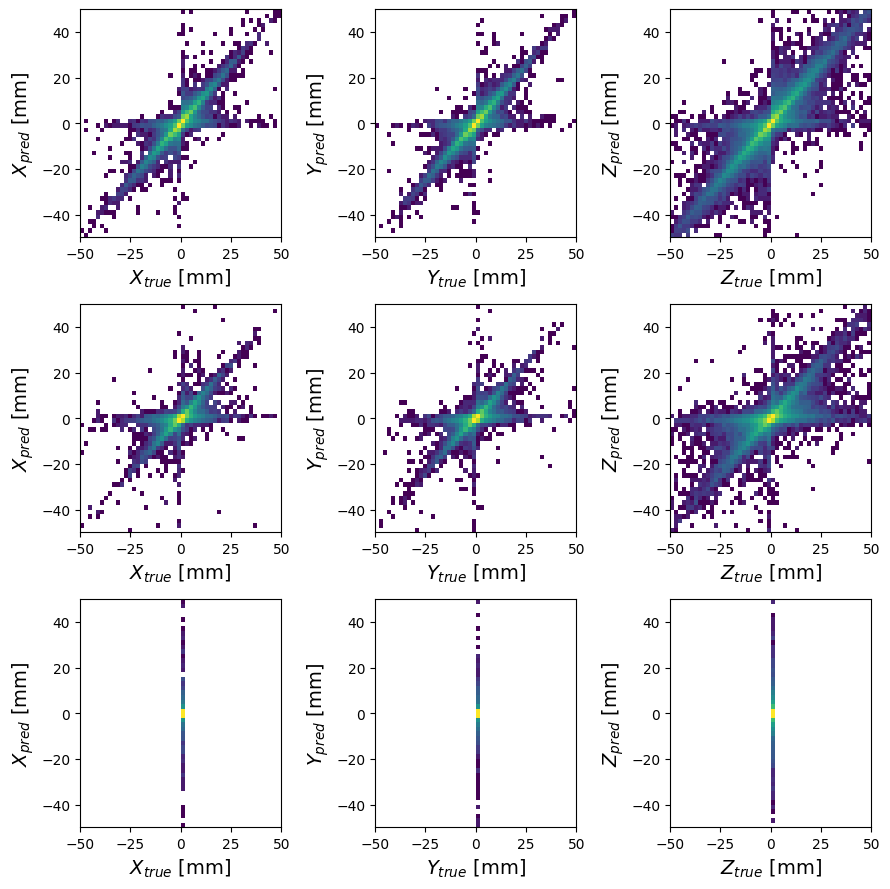

In [21]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(9,9), dpi=100)
make_2dhist_vertex_prediction(ax1, ax2, ax3, ftag_outs["b_output_arr"], ftag_outs["b_input_arr"])
make_2dhist_vertex_prediction(ax4, ax5, ax6, ftag_outs["c_output_arr"], ftag_outs["c_input_arr"])
make_2dhist_vertex_prediction(ax7, ax8, ax9, ftag_outs["u_output_arr"], ftag_outs["u_input_arr"])
fig.tight_layout()

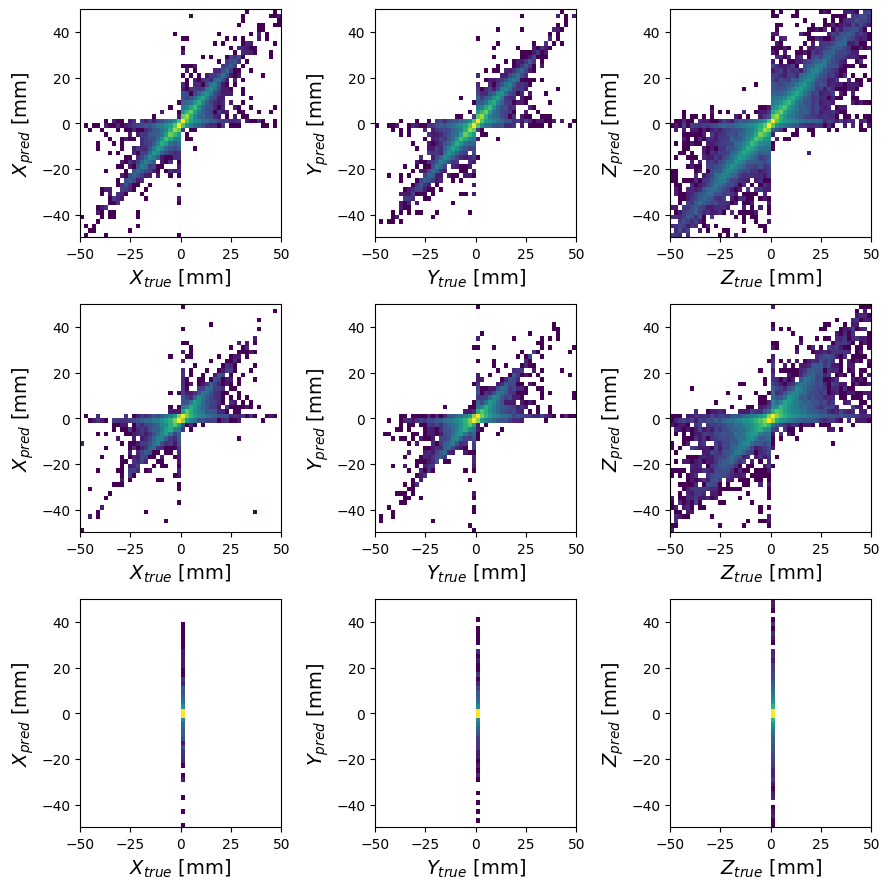

In [22]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(9,9), dpi=100)
make_2dhist_vertex_prediction(ax1, ax2, ax3, ndive_outs["b_output_arr"], ndive_outs["b_input_arr"])
make_2dhist_vertex_prediction(ax4, ax5, ax6, ndive_outs["c_output_arr"], ndive_outs["c_input_arr"])
make_2dhist_vertex_prediction(ax7, ax8, ax9, ndive_outs["u_output_arr"], ndive_outs["u_input_arr"])
fig.tight_layout()

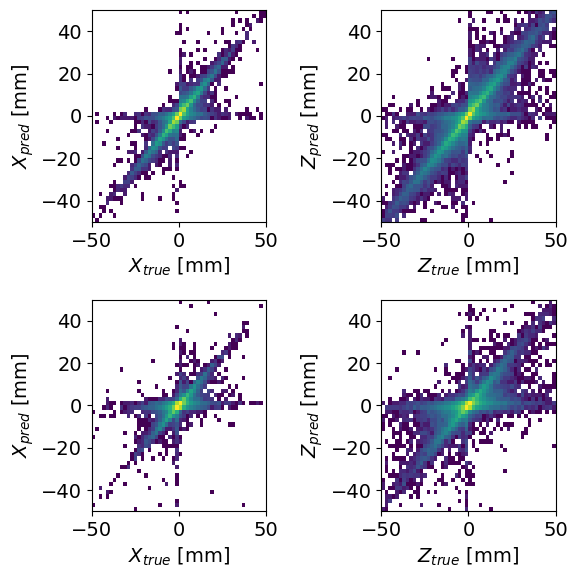

In [102]:
""" show only y,z for paper """
fig, ((ax1, ax2), (ax4, ax5)) = plt.subplots(2, 2, figsize=(6,6), dpi=100)
make_2dhist_vertex_prediction(ax1, None, ax2, ftag_outs["b_output_arr"], ftag_outs["b_input_arr"])
make_2dhist_vertex_prediction(ax4, None, ax5, ftag_outs["c_output_arr"], ftag_outs["c_input_arr"])
fig.tight_layout()

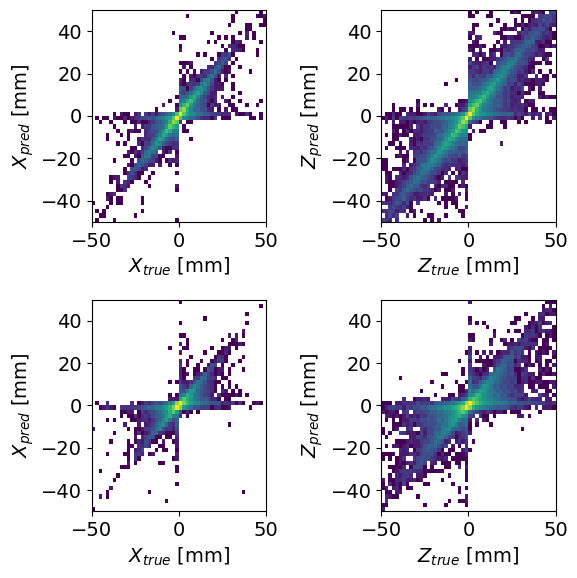

In [103]:
""" show only y,z for paper """
fig, ((ax1, ax2), (ax4, ax5)) = plt.subplots(2, 2, figsize=(6,6), dpi=100)
make_2dhist_vertex_prediction(ax1, None, ax2, ndive_outs["b_output_arr"], ndive_outs["b_input_arr"])
make_2dhist_vertex_prediction(ax4, None, ax5, ndive_outs["c_output_arr"], ndive_outs["c_input_arr"])
fig.tight_layout()
plt.savefig("plots/2Dyx_ndiveonly.png")